Old version

New correct u and v version. 

With lower Nueron and trial number

In [8]:
# ===============================================================
#  DESTINODE with neuron & lap subsampling  (variable‑K, u‑decoder)
# ===============================================================
import numpy as np, torch, matplotlib.pyplot as plt, torch.nn as nn, random
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint

# ------------------- 0. KNOBS -------------------
KEEP_NEURON_FRAC = 0.05          # 0–1   (20 % of neurons)
KEEP_LAP_FRAC    = 0.2          # 0–1   (50 % of laps per session)
RNG_SEED         = 42            # for reproducibility
torch.manual_seed(RNG_SEED); np.random.seed(RNG_SEED); random.seed(RNG_SEED)

# ------------------ 1. SETTINGS ------------------
SUBSET_FILE   = "destin_debug_subset.npz"
rank          = 10
train_days    = [0, 1, 2, 3]
test_day      = 6
epochs        = 100
LAMBDA_SMOOTH = 5e-2
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------ 2. LOAD & SUBSAMPLE ----------
data = np.load(SUBSET_FILE, allow_pickle=True)
sess_ids = sorted({int(k.split('_')[1]) for k in data if k.startswith('dff_')})

# 2a. decide once‑and‑for‑all neuron mask
N_full = data['dff_0'].shape[0]
n_keep = int(np.ceil(N_full * KEEP_NEURON_FRAC))
keep_neurons = np.random.choice(N_full, n_keep, replace=False)
keep_neurons.sort()                                      # keep order

to_tensor = lambda x: torch.tensor(x, dtype=torch.float32)
x_sess = []; v_sess = []; u_sess = []
for t in sess_ids:
    dff_full = data[f'dff_{t}'][keep_neurons]             # [N_keep, K_vr]
    dff_full = to_tensor(dff_full.T)                      # [K_vr, N_keep]
    vel_full = to_tensor(data[f'vel_{t}'])
    pos_full = to_tensor(data[f'pos_{t}'])
    pos_full = (pos_full - pos_full.mean()) / pos_full.std()

    lap_idx  = data[f'lap_idx_{t}']

    # 2b. optional lap subsampling
    all_laps = np.unique(lap_idx)
    n_laps_keep = int(np.ceil(len(all_laps) * KEEP_LAP_FRAC))
    keep_laps = np.random.choice(all_laps, n_laps_keep, replace=False)

    laps_x = []; laps_v = []; laps_u = []
    for s in sorted(keep_laps):
        mask = lap_idx == s
        if not mask.any(): continue
        laps_x.append(dff_full[mask])
        laps_v.append(vel_full[mask])
        laps_u.append(pos_full[mask])

    x_sess.append(laps_x); v_sess.append(laps_v); u_sess.append(laps_u)

T, N = len(x_sess), len(keep_neurons)
print(f"Sessions: {T} | Neurons kept: {N}/{N_full} "
      f"| Example lap shape: {x_sess[0][0].shape}")

# ------------------ 3. DATASET -------------------
class RaggedSplitDS(Dataset):
    def __init__(self, x, v, u, days):
        self.x,self.v,self.u = x,v,u
        self.map = [(t,s) for t in days for s in range(len(x[t]))]
    def __len__(self): return len(self.map)
    def __getitem__(self, idx):
        t,s = self.map[idx]
        return self.x[t][s], self.v[t][s], self.u[t][s], t

loader = DataLoader(RaggedSplitDS(x_sess,v_sess,u_sess,train_days),
                    batch_size=1, shuffle=True, collate_fn=lambda b:b)

# ------------------ 4. MODEL (unchanged except N) -----------
W0 = 0.05*torch.randn(N,N)
U,_,Vt = torch.linalg.svd(W0)
U = U[:,:rank]; V = Vt[:rank,:].T
B = 0.05*torch.randn(N,1); R = 0.05*torch.randn(1,N)

# ===============================================================
#  DAY‑0‑DRIVEN INITIALISATION  (insert before “# ------------------ 4. MODEL ---------------------”)
# ===============================================================
print("‣ deriving Day‑0 statistics for W0 and b_fixed …")

# -------- gather all frames from session‑0 after subsampling --------
X0 = torch.cat(x_sess[0], dim=0)           # [K_total_day0 , N]
X0 = X0.float()                            # ensure fp32

# -------- 1) activation bias  b_fixed -------------------------------
avg_rate = X0.mean(0)                      # mean across time
b_init   = -(avg_rate - avg_rate.mean())   # anti‑correlated w/ firing
b_init   = (0.5 / b_init.abs().max()) * b_init   # scale to ±0.5

# # -------- 2) connectivity seed  W0 ---------------------------------
# #   use Pearson correlation matrix of day‑0 activity
# X0c   = X0 - avg_rate                      # centre
# std   = X0c.std(0, unbiased=False) + 1e-9
# corr  = (X0c.T @ X0c) / X0c.shape[0]
# corr  = corr / (std[:,None] * std[None,:]) # now ρ_{ij} in [‑1,1]
# W0_init = 0.05 * corr                      # match earlier 0.05 scale

# # -------- 3) low‑rank bases from new W0 ----------------------------
# U,_,Vt = torch.linalg.svd(W0_init.cpu())
# U = U[:,:rank]; V = Vt[:rank,:].T

# print(f"   » b range  {b_init.min():.2f} … {b_init.max():.2f}")
# print(f"   » W0 diag mean±sd  {W0_init.diag().mean():.3f} ± {W0_init.diag().std():.3f}")

# # keep tensors for the model section
# W0 = W0_init.clone()
# B  = 0.05 * torch.randn(N,1)
# R  = 0.05 * torch.randn(1,N)


class SlowODE(nn.Module):
    def __init__(self,r):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(r,64), nn.Tanh(), nn.Linear(64,r))
    def forward(self,t,z): return self.net(z)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.U,self.V,self.W0 = U.to(device), V.to(device), W0.to(device)
        self.z0 = nn.Parameter(torch.zeros(rank))
        self.slow = SlowODE(rank)
        self.B = nn.Parameter(B.clone()); self.R = nn.Parameter(R.clone())
        self.b_fixed = nn.Parameter(torch.zeros(N), requires_grad=True)
        # self.b_fixed = nn.Parameter(b_init.to(device), requires_grad=False)

    def weights(self,T):
        t = torch.arange(T, dtype=torch.float32, device=self.z0.device)
        z = odeint(self.slow, self.z0[None], t).squeeze(1)       # [T,r]
        Ud   = self.U[None] * z[:,None]                          # [T,N,r]
        Vt   = self.V.T.expand(T, -1, -1)                        # [T,r,N]
        Wadd = torch.bmm(Ud, Vt)                                 # [T,N,N]
        return self.W0[None] + Wadd
    def rnn_cell(self,xk,vk,W):
        return torch.tanh(W@xk + (self.B*vk).squeeze() + self.b_fixed)
    def forward(self,x_gt,v_seq,u_seq,t_idx,Ws):
        K = x_gt.size(0); W = Ws[t_idx]
        rec = dec = 0.; x_prev = x_gt[0]
        for k in range(K-1):
            x_pred = self.rnn_cell(x_prev, v_seq[k], W)
            rec += (x_pred - x_gt[k+1]).pow(2).sum()
            dec += (self.R @ x_pred - u_seq[k]).pow(2)
            x_prev = x_pred
            # ----- inside PINN.forward  (keep all code above unchanged) -----
            lambda_rec = 1.0      # full weight on reconstruction
            lambda_dec = 0.1      # put decoder on same numeric scale

        return lambda_rec * rec + lambda_dec * dec
        

model = PINN().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-4)

# ------------------ 5. TRAIN ---------------------
for ep in range(epochs):
    total=0.
    for batch in loader:
        Ws = model.weights(T)
        losses=[]
        for x_gt,v_gt,u_gt,t_idx in batch:
            x_gt,v_gt,u_gt = (x_gt.to(device), v_gt.to(device), u_gt.to(device))
            losses.append(model(x_gt,v_gt,u_gt,t_idx,Ws))
        rec_dec = torch.stack(losses).mean()
        smooth  = (Ws[1:]-Ws[:-1]).pow(2).sum()
        loss = rec_dec + LAMBDA_SMOOTH*smooth
        opt.zero_grad(); loss.backward(); opt.step(); total+=loss.item()
    if ep%5==0:
        print(f"Epoch {ep:03d} | total {total/len(loader):.3e} "
              f"| rec+dec {rec_dec.item():.3e}")




Sessions: 8 | Neurons kept: 16/305 | Example lap shape: torch.Size([748, 16])
‣ deriving Day‑0 statistics for W0 and b_fixed …
Epoch 000 | total 3.773e+03 | rec+dec 3.442e+03
Epoch 005 | total 2.685e+03 | rec+dec 1.956e+03
Epoch 010 | total 1.867e+03 | rec+dec 1.592e+03
Epoch 015 | total 1.341e+03 | rec+dec 1.883e+03
Epoch 020 | total 9.753e+02 | rec+dec 5.585e+02
Epoch 025 | total 7.881e+02 | rec+dec 7.283e+02
Epoch 030 | total 6.881e+02 | rec+dec 5.617e+02
Epoch 035 | total 6.315e+02 | rec+dec 1.120e+03
Epoch 040 | total 6.019e+02 | rec+dec 7.150e+02
Epoch 045 | total 5.865e+02 | rec+dec 5.251e+02
Epoch 050 | total 5.777e+02 | rec+dec 5.587e+02
Epoch 055 | total 5.721e+02 | rec+dec 6.531e+02
Epoch 060 | total 5.680e+02 | rec+dec 3.483e+02
Epoch 065 | total 5.646e+02 | rec+dec 6.753e+02
Epoch 070 | total 5.619e+02 | rec+dec 5.089e+02
Epoch 075 | total 5.597e+02 | rec+dec 4.103e+02
Epoch 080 | total 5.578e+02 | rec+dec 3.553e+02
Epoch 085 | total 5.562e+02 | rec+dec 5.061e+02
Epoch 090

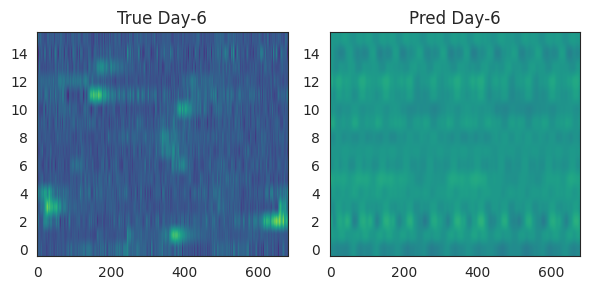

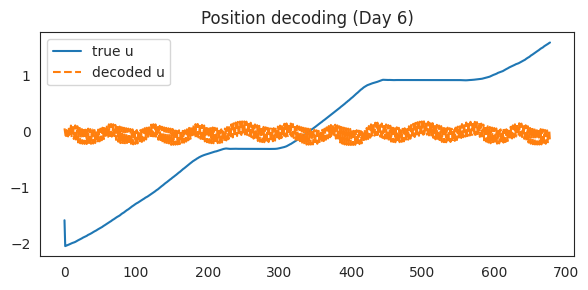

In [9]:
# ------------------ 6. EXTRAPOLATE (unchanged) --------------
Ws = model.weights(T)
x_true = x_sess[test_day][0].to(device)
v_true = v_sess[test_day][0].to(device)
u_true = u_sess[test_day][0].cpu().numpy()
K_seq  = v_true.size(0); W6 = Ws[test_day]

x_pred=[x_true[0]]
for k in range(K_seq-1):
    x_pred.append(model.rnn_cell(x_pred[-1], v_true[k], W6))
# x_pred=torch.stack(x_pred); u_pred=(model.R@x_pred.T).squeeze().cpu().numpy()
# option 1 — detach before moving to CPU
x_pred = torch.stack(x_pred).detach()             # no grad on x_pred
u_pred = (model.R @ x_pred.T).squeeze().detach().cpu().numpy()


plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(x_true.T.cpu(),aspect='auto',origin='lower',cmap='viridis')
plt.title("True Day‑6"); plt.subplot(1,2,2)
plt.imshow(x_pred.T.cpu(),aspect='auto',origin='lower',cmap='viridis'); plt.title("Pred Day‑6")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(u_true,label='true u'); plt.plot(u_pred,'--',label='decoded u')
plt.title("Position decoding (Day 6)"); plt.legend(); plt.tight_layout(); plt.show()

In [10]:
import torch

def model_device(model: torch.nn.Module) -> torch.device:
    # robust even if model has no parameters but has buffers
    try:
        return next(model.parameters()).device
    except StopIteration:
        return next(model.buffers()).device

def to_device(x, device: torch.device):
    if torch.is_tensor(x):
        return x.to(device)
    if isinstance(x, (list, tuple)):
        return type(x)(to_device(xx, device) for xx in x)
    if isinstance(x, dict):
        return {k: to_device(v, device) for k, v in x.items()}
    return x

def as_numpy(x):
    """Convert torch tensor (any device) -> numpy safely."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x


In [11]:
# # ===============================================================
# #  ADVANCED VISUALS + METRICS  (v2 — PC‑space vs position)
# # ===============================================================
# import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.metrics import r2_score
# from sklearn.linear_model import LinearRegression

# sns.set_style("white")

# # ------------------ 0. KNOBS ------------------
# REST_DAY  = 6     # session index to analyse
# LAP_ID    = 10      # lap index within the session
# NUM_BINS  = 20     # spatial bins for place‑field maps

# # ------------------ 1. RECONSTRUCT LAP --------
# Ws = model.weights(T)
# x_true = x_sess[REST_DAY][LAP_ID].to(device)        # [K, N]
# v_true = v_sess[REST_DAY][LAP_ID].to(device)
# u_true = u_sess[REST_DAY][LAP_ID].cpu().numpy()
# K_seq  = v_true.size(0)
# W_rest = Ws[REST_DAY]

# with torch.no_grad():
#     x_pred = [x_true[0]]
#     for k in range(K_seq-1):
#         x_pred.append(model.rnn_cell(x_pred[-1], v_true[k], W_rest))
#     x_pred = torch.stack(x_pred).cpu()              # [K, N]
#     u_pred = (model.R @ x_pred.T).squeeze().cpu().numpy()

# # ------------------ 2. PCA overlay ------------
# comb = torch.cat([x_true.cpu(), x_pred], dim=0).numpy()  # [2K, N]
# pca   = PCA(n_components=2).fit(comb)
# proj  = pca.transform(comb)
# true_proj, pred_proj = proj[:K_seq], proj[K_seq:]

# plt.figure(figsize=(5,4))
# plt.plot(true_proj[:,0], true_proj[:,1], 'o-', label='true')
# plt.plot(pred_proj[:,0], pred_proj[:,1], 'o-', label='pred')
# plt.title(f'PCA trajectories  (Day {REST_DAY}, Lap {LAP_ID})')
# plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# # ------------------ 3. Colour‑by‑position -----
# fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
# sc0 = axs[0].scatter(true_proj[:,0], true_proj[:,1], c=u_true, cmap='viridis', s=20)
# axs[0].set_title('True (coloured by pos)')
# sc1 = axs[1].scatter(pred_proj[:,0], pred_proj[:,1], c=u_pred, cmap='viridis', s=20)
# axs[1].set_title('Predicted (coloured by decoded pos)')
# for ax in axs: ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
# fig.colorbar(sc0, ax=axs.ravel().tolist(), label='position')
# fig.suptitle('PC space coloured by position'); plt.tight_layout(); plt.show()



# # ===============================================================
# # 2′.  THREE‑D PCA OVERLAY  (true vs predicted)
# # ===============================================================
# from mpl_toolkits.mplot3d import Axes3D   # noqa: F401  (needed for 3‑D)

# pca3  = PCA(n_components=3).fit(comb)
# proj3 = pca3.transform(comb)
# true_p3, pred_p3 = proj3[:K_seq], proj3[K_seq:]

# fig = plt.figure(figsize=(6,4))
# ax  = fig.add_subplot(111, projection='3d')
# ax.plot(true_p3[:,0], true_p3[:,1], true_p3[:,2], 'o-', label='true traj')
# ax.plot(pred_p3[:,0], pred_p3[:,1], pred_p3[:,2], 'o-', label='pred traj')
# ax.set_title(f'3‑D PCA trajectories  (Day {REST_DAY}, Lap {LAP_ID})')
# ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
# ax.legend(); plt.tight_layout(); plt.show()

# # ===============================================================
# # 3′.  3‑D PC SPACE COLOURED BY POSITION
# #      (left = true col’d by true‑pos, right = pred col’d by decoded‑pos)
# # ===============================================================
# fig = plt.figure(figsize=(10,4))
# ax0 = fig.add_subplot(121, projection='3d')
# p0  = ax0.scatter(true_p3[:,0], true_p3[:,1], true_p3[:,2],
#                   c=u_true, cmap='viridis', s=25)
# ax0.set_title('True (colour = pos)')
# ax0.set_xlabel('PC1'); ax0.set_ylabel('PC2'); ax0.set_zlabel('PC3')

# ax1 = fig.add_subplot(122, projection='3d')
# p1  = ax1.scatter(pred_p3[:,0], pred_p3[:,1], pred_p3[:,2],
#                   c=u_pred, cmap='viridis', s=25)
# ax1.set_title('Pred (colour = decoded pos)')
# ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2'); ax1.set_zlabel('PC3')

# fig.colorbar(p0, ax=[ax0,ax1], shrink=0.6, label='position')
# fig.suptitle('3‑D PC space coloured by position'); plt.tight_layout(); plt.show()


# # ------------------ 4. Place‑field maps --------
# pos_bins = np.linspace(u_true.min(), u_true.max(), NUM_BINS+1)
# bin_idx  = np.digitize(u_true, pos_bins) - 1

# def pf_map(x):
#     pf = np.zeros((NUM_BINS, x.shape[1]))
#     for b in range(NUM_BINS):
#         if not (bin_idx==b).any(): continue
#         pf[b] = x[bin_idx==b].mean(0)
#     return pf.T

# pf_true = pf_map(x_true.cpu().numpy())
# pf_pred = pf_map(x_pred.numpy())

# fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
# sns.heatmap(pf_true, ax=axs[0], cmap='hot', cbar=False)
# sns.heatmap(pf_pred, ax=axs[1], cmap='hot', cbar=False)
# axs[0].set_title('PF true'); axs[1].set_title('PF pred')
# for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
# fig.suptitle('Place‑field maps'); plt.tight_layout(); plt.show()

# # ------------------ 5. PF similarity -----------
# from scipy.stats import pearsonr
# corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
#        for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]

# plt.figure(figsize=(4,3))
# plt.hist(corrs,bins=20,color='C0');plt.title('PF similarity (r)')
# plt.xlabel('Pearson r'); plt.ylabel('# cells'); plt.tight_layout(); plt.show()
# print(f"PF r  mean={np.mean(corrs):.3f}  ±{np.std(corrs)/np.sqrt(len(corrs)):.3f}  (n={len(corrs)})")

# # ------------------ 6. PCA‑decoder accuracy ----
# reg = LinearRegression().fit(true_proj, u_true)
# u_true_pca = reg.predict(true_proj)
# u_pred_pca = reg.predict(pred_proj)

# r2_true = r2_score(u_true, u_true_pca)
# r2_pred = r2_score(u_true, u_pred_pca)

# plt.figure(figsize=(5,3))
# plt.bar(['true traj', 'pred traj'], [r2_true, r2_pred], color=['C2','C3'])
# plt.ylim(0,1); plt.ylabel('R²'); plt.title('PC1+PC2 → position decoder'); plt.tight_layout(); plt.show()
# print(f"PCA‑decoder  R² true={r2_true:.3f}   R² pred={r2_pred:.3f}")

# # ------------------ 7. Time‑series decoding ----
# plt.figure(figsize=(6,3))
# plt.plot(u_true,label='true pos'); plt.plot(u_pred,'--',label='decoded pos')
# plt.title(f'Position decoding  (R²={r2_score(u_true,u_pred):.3f})')
# plt.xlabel('frame'); plt.ylabel('position'); plt.legend(); plt.tight_layout(); plt.show()






# ===============================================================
#  ADVANCED VISUALS + METRICS  (v2 — PC-space vs position)
#  (device-safe rewrite: all torch ops stay on model device;
#   numpy conversion happens only at sklearn/seaborn boundary)
# ===============================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

sns.set_style("white")

# ------------------ helpers ------------------
def model_device(model: torch.nn.Module) -> torch.device:
    try:
        return next(model.parameters()).device
    except StopIteration:
        return next(model.buffers()).device

def to_device(x, device: torch.device):
    if torch.is_tensor(x):
        return x.to(device)
    if isinstance(x, (list, tuple)):
        return type(x)(to_device(xx, device) for xx in x)
    if isinstance(x, dict):
        return {k: to_device(v, device) for k, v in x.items()}
    return x

def as_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x

# ------------------ 0. KNOBS ------------------
REST_DAY  = 6     # session index to analyse
LAP_ID    = 10    # lap index within the session
NUM_BINS  = 20    # spatial bins for place-field maps

# ------------------ 1. RECONSTRUCT LAP --------
device = model_device(model)
model.eval()

Ws     = to_device(model.weights(T), device)                 # list/tensor safe
x_true = to_device(x_sess[REST_DAY][LAP_ID], device)         # [K, N]
v_true = to_device(v_sess[REST_DAY][LAP_ID], device)         # [K, ...]
u_true = as_numpy(u_sess[REST_DAY][LAP_ID])                  # numpy for plots/bins

K_seq  = v_true.size(0)
W_rest = to_device(Ws[REST_DAY], device)

with torch.no_grad():
    x_pred = [x_true[0]]
    for k in range(K_seq - 1):
        x_pred.append(model.rnn_cell(x_pred[-1], v_true[k], W_rest))
    x_pred = torch.stack(x_pred)                             # [K, N] stays on device

    # IMPORTANT: if model.R isn't a registered buffer/parameter, .to(model) won't move it
    R = to_device(model.R, device)
    u_pred = as_numpy((R @ x_pred.T).squeeze())

# ------------------ 2. PCA overlay ------------
comb = np.concatenate([as_numpy(x_true), as_numpy(x_pred)], axis=0)  # [2K, N]
pca  = PCA(n_components=2).fit(comb)
proj = pca.transform(comb)
true_proj, pred_proj = proj[:K_seq], proj[K_seq:]

plt.figure(figsize=(5, 4))
plt.plot(true_proj[:, 0], true_proj[:, 1], 'o-', label='true')
plt.plot(pred_proj[:, 0], pred_proj[:, 1], 'o-', label='pred')
plt.title(f'PCA trajectories  (Day {REST_DAY}, Lap {LAP_ID})')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ------------------ 3. Colour-by-position -----
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
sc0 = axs[0].scatter(true_proj[:, 0], true_proj[:, 1], c=u_true, cmap='viridis', s=20)
axs[0].set_title('True (coloured by pos)')
sc1 = axs[1].scatter(pred_proj[:, 0], pred_proj[:, 1], c=u_pred, cmap='viridis', s=20)
axs[1].set_title('Predicted (coloured by decoded pos)')
for ax in axs:
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
fig.colorbar(sc0, ax=axs.ravel().tolist(), label='position')
fig.suptitle('PC space coloured by position')
plt.tight_layout(); plt.show()

# ===============================================================
# 2′.  THREE-D PCA OVERLAY  (true vs predicted)
# ===============================================================
pca3  = PCA(n_components=3).fit(comb)
proj3 = pca3.transform(comb)
true_p3, pred_p3 = proj3[:K_seq], proj3[K_seq:]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_p3[:, 0], true_p3[:, 1], true_p3[:, 2], 'o-', label='true traj')
ax.plot(pred_p3[:, 0], pred_p3[:, 1], pred_p3[:, 2], 'o-', label='pred traj')
ax.set_title(f'3-D PCA trajectories  (Day {REST_DAY}, Lap {LAP_ID})')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend(); plt.tight_layout(); plt.show()

# ===============================================================
# 3′.  3-D PC SPACE COLOURED BY POSITION
# ===============================================================
fig = plt.figure(figsize=(10, 4))
ax0 = fig.add_subplot(121, projection='3d')
p0 = ax0.scatter(true_p3[:, 0], true_p3[:, 1], true_p3[:, 2], c=u_true, cmap='viridis', s=25)
ax0.set_title('True (colour = pos)')
ax0.set_xlabel('PC1'); ax0.set_ylabel('PC2'); ax0.set_zlabel('PC3')

ax1 = fig.add_subplot(122, projection='3d')
p1 = ax1.scatter(pred_p3[:, 0], pred_p3[:, 1], pred_p3[:, 2], c=u_pred, cmap='viridis', s=25)
ax1.set_title('Pred (colour = decoded pos)')
ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2'); ax1.set_zlabel('PC3')

fig.colorbar(p0, ax=[ax0, ax1], shrink=0.6, label='position')
fig.suptitle('3-D PC space coloured by position')
plt.tight_layout(); plt.show()

# ------------------ 4. Place-field maps --------
pos_bins = np.linspace(u_true.min(), u_true.max(), NUM_BINS + 1)
bin_idx  = np.digitize(u_true, pos_bins) - 1  # uses u_true (true position) as in your original code

def pf_map(x_np: np.ndarray) -> np.ndarray:
    # x_np: [K, N]  -> output: [N, NUM_BINS]
    pf = np.zeros((NUM_BINS, x_np.shape[1]))
    for b in range(NUM_BINS):
        m = (bin_idx == b)
        if not m.any():
            continue
        pf[b] = x_np[m].mean(0)
    return pf.T

pf_true = pf_map(as_numpy(x_true))
pf_pred = pf_map(as_numpy(x_pred))

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
sns.heatmap(pf_true, ax=axs[0], cmap='hot', cbar=False)
sns.heatmap(pf_pred, ax=axs[1], cmap='hot', cbar=False)
axs[0].set_title('PF true'); axs[1].set_title('PF pred')
for ax in axs:
    ax.set_xlabel('pos bin')
axs[0].set_ylabel('cell')
fig.suptitle('Place-field maps')
plt.tight_layout(); plt.show()

# ------------------ 5. PF similarity -----------
corrs = [
    pearsonr(pf_true[i], pf_pred[i])[0]
    for i in range(pf_true.shape[0])
    if pf_true[i].std() and pf_pred[i].std()
]

plt.figure(figsize=(4, 3))
plt.hist(corrs, bins=20, color='C0')
plt.title('PF similarity (r)')
plt.xlabel('Pearson r'); plt.ylabel('# cells')
plt.tight_layout(); plt.show()
print(f"PF r  mean={np.mean(corrs):.3f}  ±{np.std(corrs)/np.sqrt(len(corrs)):.3f}  (n={len(corrs)})")

# ------------------ 6. PCA-decoder accuracy ----
reg = LinearRegression().fit(true_proj, u_true)
u_true_pca = reg.predict(true_proj)
u_pred_pca = reg.predict(pred_proj)

r2_true = r2_score(u_true, u_true_pca)
r2_pred = r2_score(u_true, u_pred_pca)

plt.figure(figsize=(5, 3))
plt.bar(['true traj', 'pred traj'], [r2_true, r2_pred], color=['C2', 'C3'])
plt.ylim(0, 1)
plt.ylabel('R²')
plt.title('PC1+PC2 → position decoder')
plt.tight_layout(); plt.show()
print(f"PCA-decoder  R² true={r2_true:.3f}   R² pred={r2_pred:.3f}")

# ------------------ 7. Time-series decoding ----
plt.figure(figsize=(6, 3))
plt.plot(u_true, label='true pos')
plt.plot(u_pred, '--', label='decoded pos')
plt.title(f'Position decoding  (R²={r2_score(u_true, u_pred):.3f})')
plt.xlabel('frame'); plt.ylabel('position')
plt.legend(); plt.tight_layout(); plt.show()


IndexError: list index out of range

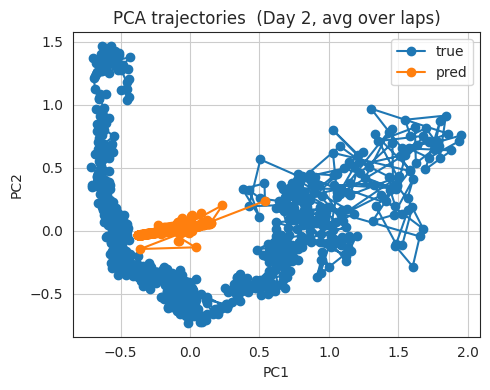

/tmp/ipykernel_244566/474810913.py:278: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


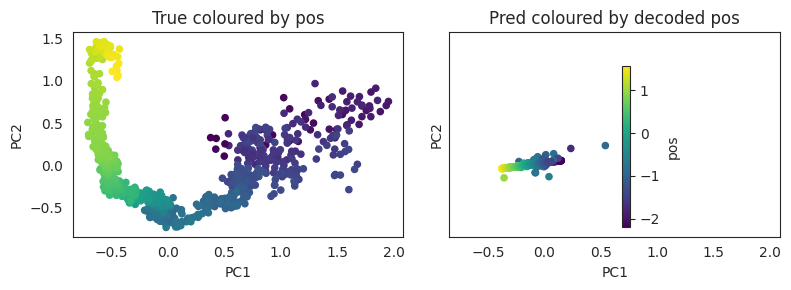

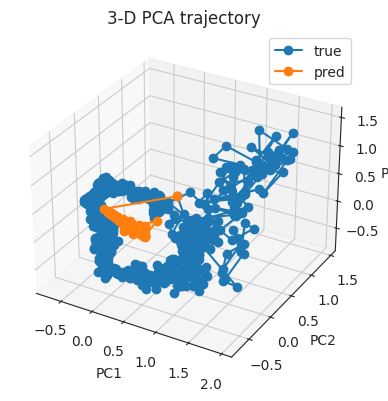

/tmp/ipykernel_244566/474810913.py:307: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


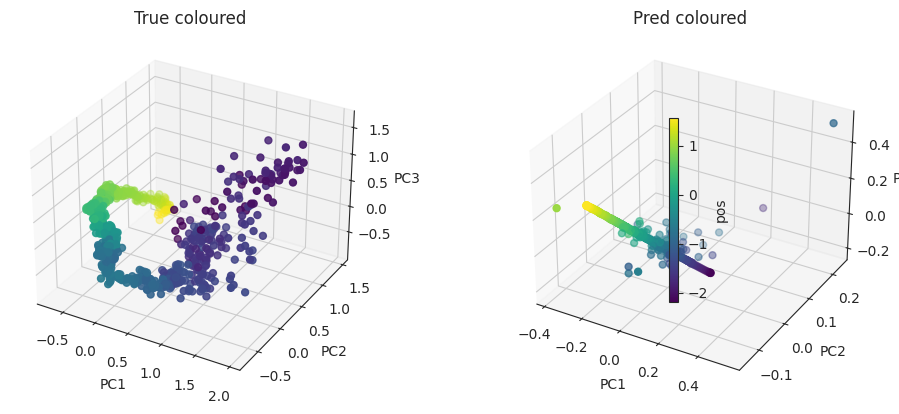

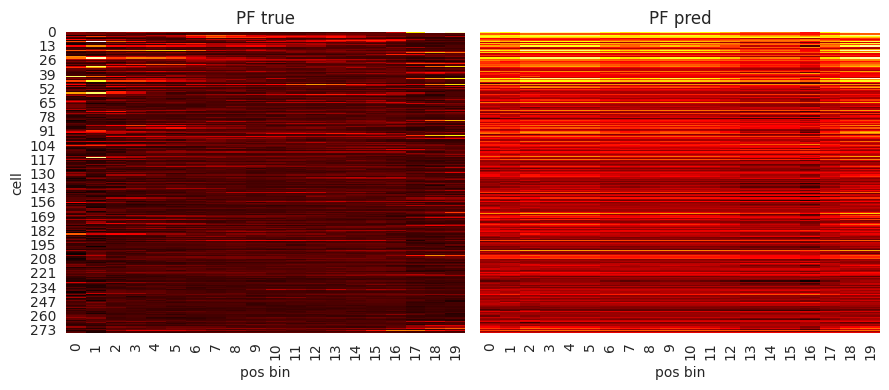

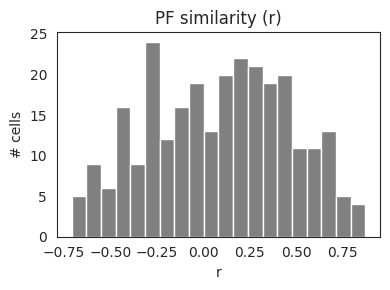

PF r mean=0.087 ± 0.023 (n=275)
PC decoder R²  true=0.914   pred=0.036


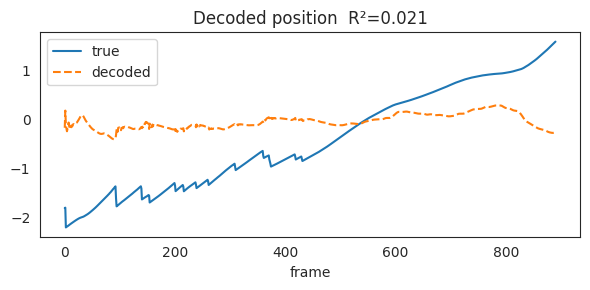

In [ ]:
# # ===============================================================
# #  ADVANCED VISUALS + METRICS  (with optional lap‑averaging)
# # ===============================================================
# import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from scipy.stats import pearsonr
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# sns.set_style("white")

# # ------------------ 0. KNOBS ------------------
# REST_DAY      = 2      # which session to analyse
# LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
# NUM_BINS      = 20
# AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY

# # ------------------ 1. COLLECT / AVERAGE  ---------------------
# Ws = model.weights(T)
# W_day = Ws[REST_DAY]

# def reconstruct(lap_idx):
#     x_t = x_sess[REST_DAY][lap_idx].to(device)
#     v_t = v_sess[REST_DAY][lap_idx].to(device)
#     u_t = u_sess[REST_DAY][lap_idx].cpu().numpy()
#     K   = v_t.size(0)
#     with torch.no_grad():
#         x_p=[x_t[0]]
#         for k in range(K-1):
#             x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
#         x_p  = torch.stack(x_p).cpu()                    # [K,N]
#         u_p  = (model.R @ x_p.T).squeeze().cpu().numpy() # [K]
#     return x_t.cpu(), x_p, u_t, u_p, K

# if AVG_OVER_LAPS:
#     all_x_true = []; all_x_pred = []; all_u_true = []; all_u_pred = []
#     K_max = max(len(v) for v in v_sess[REST_DAY])
#     for li in range(len(x_sess[REST_DAY])):
#         xT,xP,uT,uP,K = reconstruct(li)
#         pad = (K_max-K,0)  # pad at *front* so starts align
#         all_x_true.append(torch.nn.functional.pad(xT, pad=(0,0,*pad)))
#         all_x_pred.append(torch.nn.functional.pad(xP, pad=(0,0,*pad)))
#         all_u_true.append(np.pad(uT, pad, constant_values=np.nan))
#         all_u_pred.append(np.pad(uP, pad, constant_values=np.nan))
#     x_true = torch.stack(all_x_true).nanmean(0)   # [K_max,N]
#     x_pred = torch.stack(all_x_pred).nanmean(0)
#     u_true = np.nanmean(np.vstack(all_u_true),0)
#     u_pred = np.nanmean(np.vstack(all_u_pred),0)
#     K_seq  = K_max
# else:  # single lap path
#     x_true,x_pred,u_true,u_pred,K_seq = reconstruct(LAP_ID)[:5]

# # ------------------ 2. PCA overlay (2‑D) ----------------------
# comb = torch.cat([x_true, x_pred], dim=0).numpy()  # [2K,N]
# pca2 = PCA(n_components=2).fit(comb)
# proj2= pca2.transform(comb)
# true_p2,pred_p2 = proj2[:K_seq], proj2[K_seq:]

# plt.figure(figsize=(5,4))
# plt.plot(true_p2[:,0], true_p2[:,1],'o-',label='true')
# plt.plot(pred_p2[:,0], pred_p2[:,1],'o-',label='pred')
# ttl = "avg" if AVG_OVER_LAPS else f"lap {LAP_ID}"
# plt.title(f'PCA trajectories  (Day {REST_DAY}, {ttl})')
# plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# # ------------------ 3. PC space colour‑by‑pos (2‑D) ----------
# fig,axs=plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)
# axs[0].scatter(true_p2[:,0], true_p2[:,1], c=u_true, cmap='viridis', s=20)
# axs[0].set_title('True coloured by pos')
# axs[1].scatter(pred_p2[:,0], pred_p2[:,1], c=u_pred, cmap='viridis', s=20)
# axs[1].set_title('Pred coloured by decoded pos')
# for ax in axs: ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
# fig.colorbar(axs[0].collections[0], ax=axs, shrink=0.7, label='pos')
# plt.tight_layout(); plt.show()

# # ------------------ 4. 3‑D PCA overlay -----------------------
# pca3 = PCA(n_components=3).fit(comb); proj3=pca3.transform(comb)
# true_p3,pred_p3 = proj3[:K_seq], proj3[K_seq:]

# fig=plt.figure(figsize=(6,4)); ax=fig.add_subplot(111,projection='3d')
# ax.plot(*true_p3.T,'o-',label='true'); ax.plot(*pred_p3.T,'o-',label='pred')
# ax.set_title('3‑D PCA trajectory'); ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
# ax.legend(); plt.tight_layout(); plt.show()

# # ------------------ 5. 3‑D colour‑by‑pos ---------------------
# fig=plt.figure(figsize=(10,4))
# ax0=fig.add_subplot(121,projection='3d')
# sc=ax0.scatter(*true_p3.T,c=u_true,cmap='viridis',s=25); ax0.set_title('True coloured')
# ax1=fig.add_subplot(122,projection='3d')
# ax1.scatter(*pred_p3.T,c=u_pred,cmap='viridis',s=25); ax1.set_title('Pred coloured')
# for ax in [ax0,ax1]:
#     ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
# fig.colorbar(sc,ax=[ax0,ax1],shrink=0.6,label='pos'); plt.tight_layout(); plt.show()

# # ------------------ 6. Place‑field maps ----------------------
# pos_bins=np.linspace(u_true.min(),u_true.max(),NUM_BINS+1)
# bin_idx=np.digitize(u_true,pos_bins)-1
# def pf(x):
#     P=np.zeros((NUM_BINS,x.shape[1]))
#     for b in range(NUM_BINS):
#         if not (bin_idx==b).any(): continue
#         P[b]=x[bin_idx==b].mean(0)
#     return P.T
# pf_true,pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

# fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
# sns.heatmap(pf_true,ax=axs[0],cmap='hot',cbar=False);axs[0].set_title('PF true')
# sns.heatmap(pf_pred,ax=axs[1],cmap='hot',cbar=False);axs[1].set_title('PF pred')
# for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
# plt.tight_layout(); plt.show()

# # ------------------ 7. PF similarity histogram --------------
# corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
#        for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]
# plt.figure(figsize=(4,3)); plt.hist(corrs,bins=20,color='gray')
# plt.title('PF similarity (r)'); plt.xlabel('r'); plt.ylabel('# cells'); plt.tight_layout(); plt.show()
# print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f}")

# # ------------------ 8. PCA‑decoder accuracy ------------------
# reg = LinearRegression().fit(true_p2, u_true)
# print(f"PC decoder R²  true={r2_score(u_true, reg.predict(true_p2)):.3f}   "
#       f"pred={r2_score(u_true, reg.predict(pred_p2)):.3f}")

# # ------------------ 9. Time‑series decoding -----------------
# plt.figure(figsize=(6,3))
# plt.plot(u_true,label='true'); plt.plot(u_pred,'--',label='decoded')
# plt.title(f'Decoded position  R²={r2_score(u_true,u_pred):.3f}')
# plt.xlabel('frame'); plt.legend(); plt.tight_layout(); plt.show()




# ===============================================================
#  ADVANCED VISUALS + METRICS  (with optional lap-averaging)
#  Device-safe + pad-safe rewrite
# ===============================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

sns.set_style("white")

# ------------------ 0. KNOBS ------------------
REST_DAY      = 2      # which session to analyse
LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
NUM_BINS      = 20
AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY


# ------------------ helpers -------------------
def _model_device(m: torch.nn.Module) -> torch.device:
    try:
        return next(m.parameters()).device
    except StopIteration:
        return next(m.buffers()).device

def _to_device(x, device: torch.device):
    if torch.is_tensor(x):
        return x.to(device)
    if isinstance(x, (list, tuple)):
        return type(x)(_to_device(xx, device) for xx in x)
    if isinstance(x, dict):
        return {k: _to_device(v, device) for k, v in x.items()}
    return x

def _as_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x


# ------------------ 1. COLLECT / AVERAGE ---------------------
device = _model_device(model)
model.eval()

Ws    = _to_device(model.weights(T), device)
W_day = _to_device(Ws[REST_DAY], device)

# Ensure R follows model device even if it's not registered as a buffer
R = _to_device(model.R, device)

def reconstruct(lap_idx: int):
    """
    Returns:
        x_t_cpu: [K, N] torch on CPU
        x_p_cpu: [K, N] torch on CPU
        u_t:     [K] numpy
        u_p:     [K] numpy
        K:       int
    """
    x_t = x_sess[REST_DAY][lap_idx].to(device)
    v_t = v_sess[REST_DAY][lap_idx].to(device)
    u_t = _as_numpy(u_sess[REST_DAY][lap_idx])
    K   = int(v_t.size(0))

    with torch.no_grad():
        x_p = [x_t[0]]
        for k in range(K - 1):
            x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
        x_p = torch.stack(x_p)                    # [K, N] on device
        u_p = _as_numpy((R @ x_p.T).squeeze())     # [K] numpy

    return x_t.detach().cpu(), x_p.detach().cpu(), u_t, u_p, K

if AVG_OVER_LAPS:
    L = len(x_sess[REST_DAY])
    K_max = max(int(v.size(0)) for v in v_sess[REST_DAY])

    all_x_true = []
    all_x_pred = []
    all_u_true = []
    all_u_pred = []

    # Build padded stacks (torch padded with 0; numpy padded with NaN)
    for li in range(L):
        xT, xP, uT, uP, K = reconstruct(li)
        padK = K_max - K

        # torch: pad along time (front) with zeros
        all_x_true.append(torch.nn.functional.pad(xT, pad=(0, 0, padK, 0)))  # [K_max, N]
        all_x_pred.append(torch.nn.functional.pad(xP, pad=(0, 0, padK, 0)))

        # numpy: pad front with NaNs (ignored in nanmean)
        all_u_true.append(np.pad(uT, (padK, 0), constant_values=np.nan))
        all_u_pred.append(np.pad(uP, (padK, 0), constant_values=np.nan))

    X_true = torch.stack(all_x_true, dim=0)  # [L, K_max, N]
    X_pred = torch.stack(all_x_pred, dim=0)

    # mask = 1 where valid frames, 0 where padded
    mask = torch.zeros((L, K_max, 1), dtype=X_true.dtype)
    for li in range(L):
        K = int(v_sess[REST_DAY][li].size(0))
        mask[li, K_max - K:, 0] = 1.0

    denom = mask.sum(0).clamp_min(1.0)       # [K_max, 1]
    x_true = (X_true * mask).sum(0) / denom  # [K_max, N] torch (CPU)
    x_pred = (X_pred * mask).sum(0) / denom  # [K_max, N] torch (CPU)

    u_true = np.nanmean(np.vstack(all_u_true), axis=0)
    u_pred = np.nanmean(np.vstack(all_u_pred), axis=0)

    K_seq = K_max
else:
    x_true, x_pred, u_true, u_pred, K_seq = reconstruct(LAP_ID)


# ------------------ 2. PCA overlay (2-D) ----------------------
comb = torch.cat([x_true, x_pred], dim=0).numpy()  # [2K, N] (CPU)
pca2 = PCA(n_components=2).fit(comb)
proj2 = pca2.transform(comb)
true_p2, pred_p2 = proj2[:K_seq], proj2[K_seq:]

plt.figure(figsize=(5, 4))
plt.plot(true_p2[:, 0], true_p2[:, 1], 'o-', label='true')
plt.plot(pred_p2[:, 0], pred_p2[:, 1], 'o-', label='pred')
ttl = "avg over laps" if AVG_OVER_LAPS else f"lap {LAP_ID}"
plt.title(f'PCA trajectories  (Day {REST_DAY}, {ttl})')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# ------------------ 3. PC space colour-by-pos (2-D) ----------
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
s0 = axs[0].scatter(true_p2[:, 0], true_p2[:, 1], c=u_true, cmap='viridis', s=20)
axs[0].set_title('True coloured by pos')
s1 = axs[1].scatter(pred_p2[:, 0], pred_p2[:, 1], c=u_pred, cmap='viridis', s=20)
axs[1].set_title('Pred coloured by decoded pos')
for ax in axs:
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
fig.colorbar(s0, ax=axs.ravel().tolist(), shrink=0.7, label='pos')
plt.tight_layout(); plt.show()


# ------------------ 4. 3-D PCA overlay -----------------------
pca3 = PCA(n_components=3).fit(comb)
proj3 = pca3.transform(comb)
true_p3, pred_p3 = proj3[:K_seq], proj3[K_seq:]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*true_p3.T, 'o-', label='true')
ax.plot(*pred_p3.T, 'o-', label='pred')
ax.set_title('3-D PCA trajectory')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.legend()
plt.tight_layout(); plt.show()


# ------------------ 5. 3-D colour-by-pos ---------------------
fig = plt.figure(figsize=(10, 4))
ax0 = fig.add_subplot(121, projection='3d')
sc = ax0.scatter(*true_p3.T, c=u_true, cmap='viridis', s=25)
ax0.set_title('True coloured')
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(*pred_p3.T, c=u_pred, cmap='viridis', s=25)
ax1.set_title('Pred coloured')
for a in (ax0, ax1):
    a.set_xlabel('PC1'); a.set_ylabel('PC2'); a.set_zlabel('PC3')
fig.colorbar(sc, ax=[ax0, ax1], shrink=0.6, label='pos')
plt.tight_layout(); plt.show()


# ------------------ 6. Place-field maps ----------------------
# (binning uses true position u_true; if u_true contains NaNs from averaging, ignore them)
valid = np.isfinite(u_true)
u_true_valid = u_true[valid]

pos_bins = np.linspace(u_true_valid.min(), u_true_valid.max(), NUM_BINS + 1)
bin_idx = np.full(u_true.shape, -1, dtype=int)
bin_idx[valid] = np.digitize(u_true_valid, pos_bins) - 1

def pf(x_np: np.ndarray) -> np.ndarray:
    # x_np: [K, N]
    P = np.zeros((NUM_BINS, x_np.shape[1]))
    for b in range(NUM_BINS):
        m = (bin_idx == b)
        if not m.any():
            continue
        P[b] = x_np[m].mean(0)
    return P.T  # [N, NUM_BINS]

pf_true = pf(x_true.numpy())
pf_pred = pf(x_pred.numpy())

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
sns.heatmap(pf_true, ax=axs[0], cmap='hot', cbar=False)
axs[0].set_title('PF true')
sns.heatmap(pf_pred, ax=axs[1], cmap='hot', cbar=False)
axs[1].set_title('PF pred')
for ax in axs:
    ax.set_xlabel('pos bin')
axs[0].set_ylabel('cell')
plt.tight_layout(); plt.show()


# ------------------ 7. PF similarity histogram --------------
corrs = [
    pearsonr(pf_true[i], pf_pred[i])[0]
    for i in range(pf_true.shape[0])
    if pf_true[i].std() and pf_pred[i].std()
]
plt.figure(figsize=(4, 3))
plt.hist(corrs, bins=20, color='gray')
plt.title('PF similarity (r)')
plt.xlabel('r'); plt.ylabel('# cells')
plt.tight_layout(); plt.show()
if len(corrs) > 0:
    print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f} (n={len(corrs)})")
else:
    print("PF similarity: no valid cells (all-zero/constant PFs).")


# ------------------ 8. PCA-decoder accuracy ------------------
reg = LinearRegression().fit(true_p2, u_true)
r2_true = r2_score(u_true, reg.predict(true_p2))
r2_pred = r2_score(u_true, reg.predict(pred_p2))
print(f"PC decoder R²  true={r2_true:.3f}   pred={r2_pred:.3f}")


# ------------------ 9. Time-series decoding -----------------
plt.figure(figsize=(6, 3))
plt.plot(u_true, label='true')
plt.plot(u_pred, '--', label='decoded')
plt.title(f'Decoded position  R²={r2_score(u_true, u_pred):.3f}')
plt.xlabel('frame')
plt.legend()
plt.tight_layout(); plt.show()


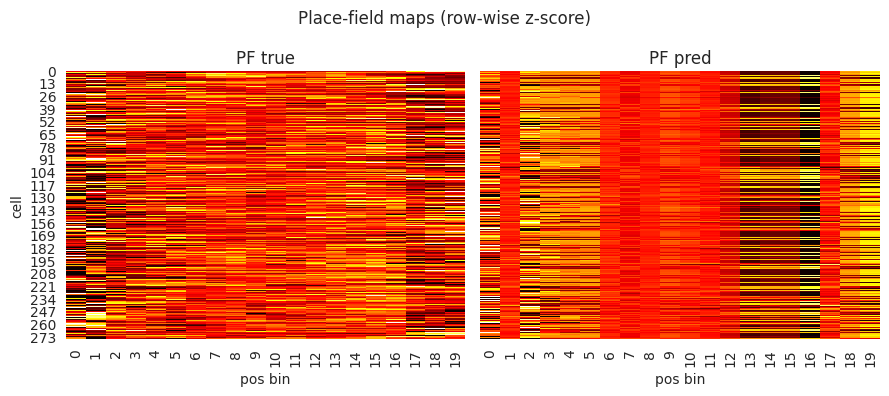

In [ ]:
# ---------- Better place‑field visualisation ----------
def plot_pfs(pf_true, pf_pred, mode="global"):
    """
    mode = "global"  : shared colour limits (0…99th percentile of both maps)
           "row-z"   : z‑score each cell before plotting
    """
    def zscore_rows(arr):
        m = arr.mean(1, keepdims=True)
        s = arr.std(1, keepdims=True) + 1e-9
        return (arr-m)/s
    
    def minmax_rows(arr):
        mn = arr.min(1, keepdims=True)
        mx = arr.max(1, keepdims=True)
        return (arr-mn) / (mx-mn + 1e-9)

    A = minmax_rows(pf_true)
    B = minmax_rows(pf_pred)
    vmin, vmax = 0, 1


    A = zscore_rows(pf_true) if mode=="row-z" else pf_true
    B = zscore_rows(pf_pred) if mode=="row-z" else pf_pred

    if mode=="global":
        perc = np.percentile(np.r_[A,B], [1,99])
        vmin,vmax = perc      # shared scale
    else:                     # row‑z already centred
        vmin,vmax = -2, 3

    order = np.argsort(np.argmax(A,1))        # sort by peak bin of TRUE map
    # A,B = A[order], B[order]

    fig,axs = plt.subplots(1,2,figsize=(9,4),sharey=True)
    sns.heatmap(A, ax=axs[0], cmap='hot', vmin=vmin, vmax=vmax, cbar=False)
    sns.heatmap(B, ax=axs[1], cmap='hot', vmin=vmin, vmax=vmax, cbar=False)
    axs[0].set_title('PF true'); axs[1].set_title('PF pred')
    for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
    st = "shared scale" if mode=="global" else "row‑wise z‑score"
    fig.suptitle(f'Place‑field maps ({st})'); plt.tight_layout(); plt.show()

# --- call it ---
plot_pfs(pf_true, pf_pred, mode="row-z")



#  DESTINODE – sanity‑check notebook cell

Held‑out Lap  R² = 0.069


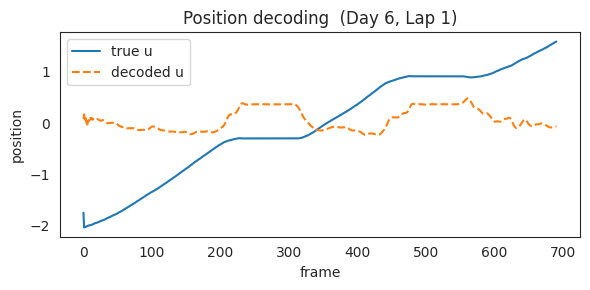

IndexError: list index out of range

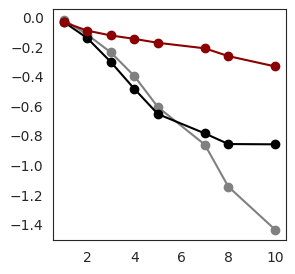

In [ ]:
# ============================================================
#  DESTINODE – sanity‑check notebook cell
# ============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

# ------------ 1) hold‑out lap decoding quality --------------
# pick Day 6 • Lap 1  (change indices if you prefer)
lap_idx_test = 1
x_true_ho = x_sess[test_day][lap_idx_test].to(device)
v_true_ho = v_sess[test_day][lap_idx_test].to(device)
u_true_ho = u_sess[test_day][lap_idx_test].cpu().numpy()
K_ho       = v_true_ho.size(0)

# run network with learned W(test_day)
W_td = model.weights(T)[test_day]
x_pred_ho = [x_true_ho[0]]
for k in range(K_ho-1):
    x_pred_ho.append(model.rnn_cell(x_pred_ho[-1], v_true_ho[k], W_td))
x_pred_ho = torch.stack(x_pred_ho)
u_pred_ho = (model.R @ x_pred_ho.T).squeeze().detach().cpu().numpy()

# R²
r2 = r2_score(u_true_ho, u_pred_ho)
print(f"Held‑out Lap  R² = {r2:.3f}")

# plot
plt.figure(figsize=(6,3))
plt.plot(u_true_ho, label='true u'); plt.plot(u_pred_ho,'--', label='decoded u')
plt.title(f"Position decoding  (Day {test_day}, Lap {lap_idx_test})")
plt.xlabel("frame"); plt.ylabel("position"); plt.legend(); plt.tight_layout(); plt.show()



# ------------ 2) latent drift trajectory z(t) ---------------

T_day_label = [1,2,3,4,5,7,8,10]

with torch.no_grad():
    t_axis = torch.arange(T, dtype=torch.float32, device=device)
    z_traj = odeint(model.slow, model.z0.unsqueeze(0), t_axis).squeeze(1).cpu().numpy()

plt.figure(figsize=(3,3))
colors = [ 'gray', 'black','darkred']
for i in range(z_traj.shape[1]):
    plt.plot(T_day_label, z_traj[:, i], '-o', label=f'z[{i}]', color=colors[i])
plt.title("Latent drift components z(t)")
plt.xlabel("session (t)"); plt.ylabel("value"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


# ------------ 3) input‑weight pattern B ---------------------
B_np = model.B.detach().cpu().numpy().squeeze()   # shape [N]
plt.figure(figsize=(5,3))
plt.plot(B_np)
plt.title("Input weight vector B")
plt.xlabel("neuron"); plt.ylabel("weight"); plt.tight_layout(); plt.show()


In [10]:
T

8

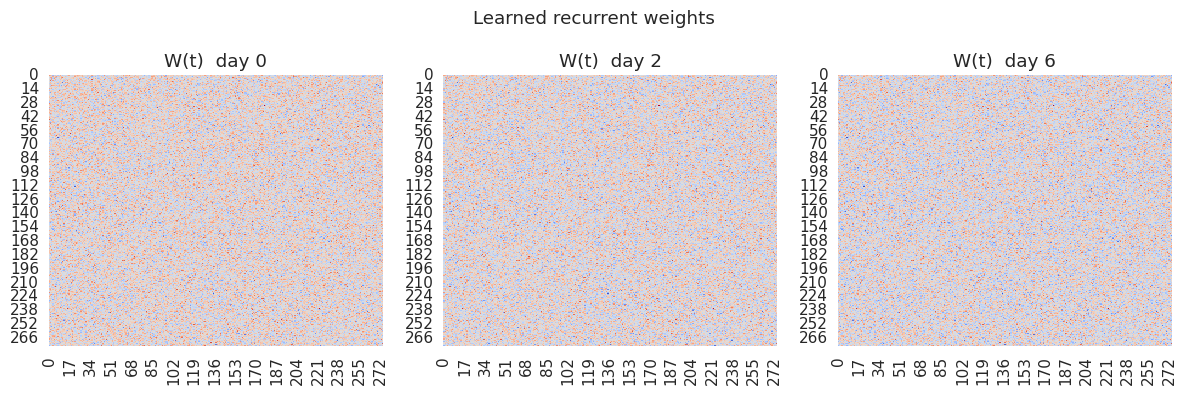

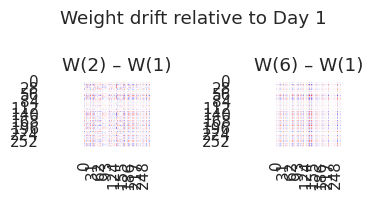

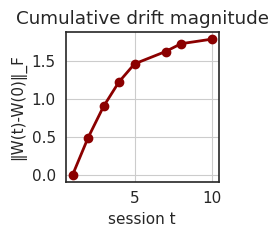

In [11]:
# ============================================================
#  Weight‑matrix diagnostics  (heat‑maps & drift magnitude)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
T_day_label = [1,2,3,4,5,7,8,10]
Ws_np = model.weights(T).detach().cpu().numpy()   # shape [T, N, N]

# ---------- 1) absolute matrices ----------
days_to_show = [0, train_days[-2], test_day]      # Day0, Day3, Day6
fig, axes = plt.subplots(1, len(days_to_show), figsize=(4*len(days_to_show),4))
for ax, t in zip(axes, days_to_show):
    sns.heatmap(Ws_np[t], ax=ax, cmap='coolwarm', cbar=False)
    ax.set_title(f"W(t)  day {t}")
plt.suptitle("Learned recurrent weights"); plt.tight_layout(); plt.show()

# ---------- 2) differences  W(t) - W(0) ----------
fig, axes = plt.subplots(1, len(days_to_show)-1, figsize=(2*(len(days_to_show)-1),2))
for ax, t in zip(axes, days_to_show[1:]):
    diff = Ws_np[t] - Ws_np[0]
    sns.heatmap(diff, ax=ax, cmap='bwr', center=0, cbar=False)
    ax.set_title(f"W({t}) – W(1)")
    ax.axis('equal')
plt.suptitle("Weight drift relative to Day 1"); plt.tight_layout(); plt.show()

# ---------- 3) Frobenius‑norm drift magnitude ----------
fro_norm = [np.linalg.norm(Ws_np[t] - Ws_np[0]) for t in range(T)]
plt.figure(figsize=(2.5,2.5))
plt.plot(T_day_label,fro_norm, '-o', color = 'darkred',linewidth = 2); plt.xlabel('session t'); plt.ylabel('‖W(t)-W(0)‖_F')
plt.title("Cumulative drift magnitude"); plt.grid(True); plt.tight_layout(); plt.show()


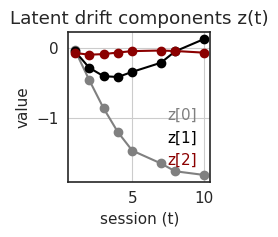

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(2.5, 2.5))
colors = ['gray', 'black', 'darkred']
for i in range(z_traj.shape[1]):
    plt.plot(T_day_label, z_traj[:, i], '-o', color=colors[i])

# Create custom legend handles with matching text color
custom_legend = [
    Line2D([0], [0], linestyle='None', marker='', color=colors[0], label='z[0]'),
    Line2D([0], [0], linestyle='None', marker='', color=colors[1], label='z[1]'),
    Line2D([0], [0], linestyle='None', marker='', color=colors[2], label='z[2]')
]

legend = plt.legend(handles=custom_legend, loc='lower right', frameon=False)
# Match legend text color to corresponding line
for text, color in zip(legend.get_texts(), colors):
    text.set_color(color)

plt.title("Latent drift components z(t)")
plt.xlabel("session (t)")
plt.ylabel("value")
plt.grid(True)
plt.tight_layout()
plt.show()


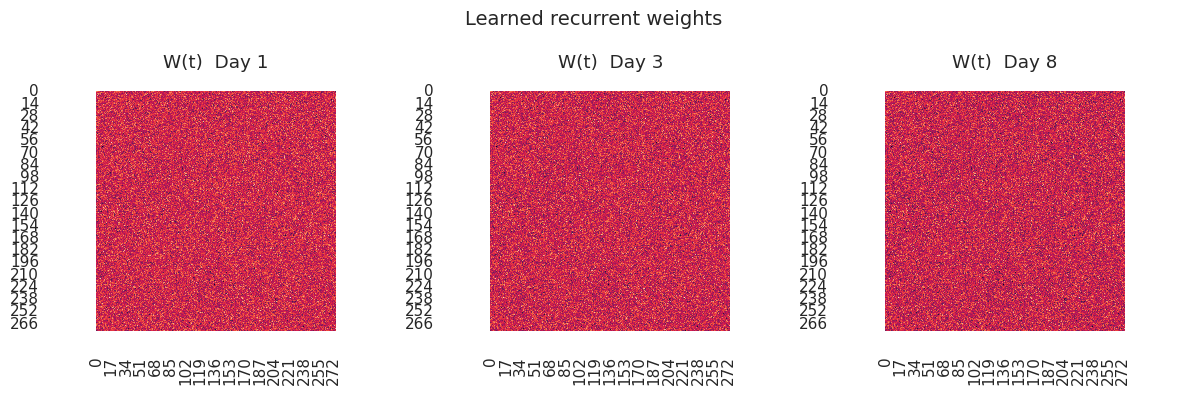

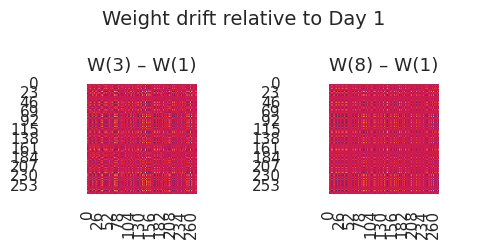

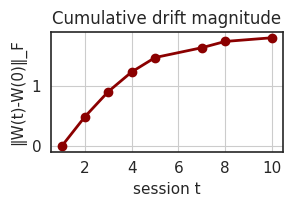

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("white")

T_day_label = [1,2,3,4,5,7,8,10]
Ws_np = model.weights(T).detach().cpu().numpy()   # shape [T, N, N]

# ---------- 1) Absolute weight matrices ----------
days_to_show = [0, train_days[-2], test_day]  # Day0, Day3, Day6
fig, axes = plt.subplots(1, len(days_to_show), figsize=(4*len(days_to_show), 4))
for ax, t in zip(axes, days_to_show):
    sns.heatmap(Ws_np[t], ax=ax, cmap='rocket', cbar=False)
    ax.set_title(f"W(t)  Day {T_day_label[t]}")
    ax.axis('equal')
plt.suptitle("Learned recurrent weights", fontsize=14)
plt.tight_layout(); plt.show()

# ---------- 2) Differences W(t) - W(0) ----------
fig, axes = plt.subplots(1, len(days_to_show)-1, figsize=(2.5*(len(days_to_show)-1), 2.5))
for ax, t in zip(axes, days_to_show[1:]):
    diff = Ws_np[t] - Ws_np[0]
    sns.heatmap(diff, ax=ax, cmap='rocket', center=0, cbar=False)
    ax.set_title(f"W({T_day_label[t]}) – W(1)")
    ax.axis('equal')
plt.suptitle("Weight drift relative to Day 1", fontsize=14)
plt.tight_layout(); plt.show()

# ---------- 3) Frobenius-norm drift magnitude ----------
fro_norm = [np.linalg.norm(Ws_np[t] - Ws_np[0]) for t in range(T)]
plt.figure(figsize=(3.2, 2.2))
plt.plot(T_day_label, fro_norm, '-o', color='darkred', linewidth=2)
plt.xlabel('session t'); plt.ylabel('‖W(t)-W(0)‖_F')
plt.title("Cumulative drift magnitude", fontsize=12)
plt.grid(True); plt.tight_layout(); plt.show()


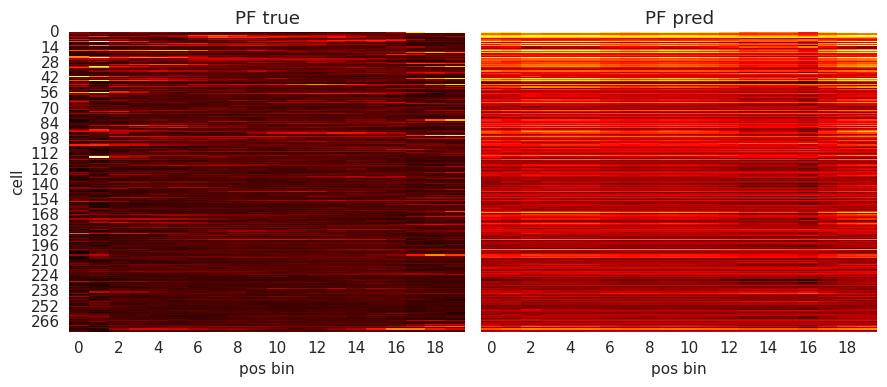

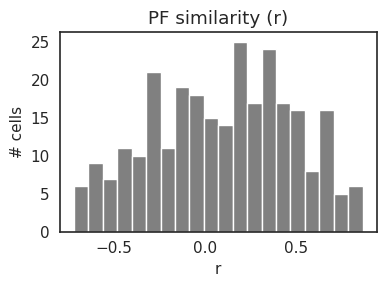

PF r mean=0.097 ± 0.023 (n=275)
PC decoder R²  true=0.913   pred=0.048


In [14]:
# # ===============================================================
# #  ADVANCED VISUALS + METRICS  (with optional lap‑averaging)
# # ===============================================================
# import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from scipy.stats import pearsonr
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# sns.set_style("white")

# # ------------------ 0. KNOBS ------------------
# REST_DAY      = 2      # which session to analyse
# LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
# NUM_BINS      = 20
# AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY

# # ------------------ 1. COLLECT / AVERAGE  ---------------------
# Ws = model.weights(T)
# W_day = Ws[REST_DAY]

# def reconstruct(lap_idx):
#     x_t = x_sess[REST_DAY][lap_idx].to(device)
#     v_t = v_sess[REST_DAY][lap_idx].to(device)
#     u_t = u_sess[REST_DAY][lap_idx].cpu().numpy()
#     K   = v_t.size(0)
#     with torch.no_grad():
#         x_p=[x_t[0]]
#         for k in range(K-1):
#             x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
#         x_p  = torch.stack(x_p).cpu()                    # [K,N]
#         u_p  = (model.R @ x_p.T).squeeze().cpu().numpy() # [K]
#     return x_t.cpu(), x_p, u_t, u_p, K

# if AVG_OVER_LAPS:
#     all_x_true = []; all_x_pred = []; all_u_true = []; all_u_pred = []
#     K_max = max(len(v) for v in v_sess[REST_DAY])
#     for li in range(len(x_sess[REST_DAY])):
#         xT,xP,uT,uP,K = reconstruct(li)
#         pad = (K_max-K,0)  # pad at *front* so starts align
#         all_x_true.append(torch.nn.functional.pad(xT, pad=(0,0,*pad)))
#         all_x_pred.append(torch.nn.functional.pad(xP, pad=(0,0,*pad)))
#         all_u_true.append(np.pad(uT, pad, constant_values=np.nan))
#         all_u_pred.append(np.pad(uP, pad, constant_values=np.nan))
#     x_true = torch.stack(all_x_true).nanmean(0)   # [K_max,N]
#     x_pred = torch.stack(all_x_pred).nanmean(0)
#     u_true = np.nanmean(np.vstack(all_u_true),0)
#     u_pred = np.nanmean(np.vstack(all_u_pred),0)
#     K_seq  = K_max
# else:  # single lap path
#     x_true,x_pred,u_true,u_pred,K_seq = reconstruct(LAP_ID)[:5]




# # ------------------ 6. Place‑field maps ----------------------
# pos_bins=np.linspace(u_true.min(),u_true.max(),NUM_BINS+1)
# bin_idx=np.digitize(u_true,pos_bins)-1
# def pf(x):
#     P=np.zeros((NUM_BINS,x.shape[1]))
#     for b in range(NUM_BINS):
#         if not (bin_idx==b).any(): continue
#         P[b]=x[bin_idx==b].mean(0)
#     return P.T
# pf_true,pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

# fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
# sns.heatmap(pf_true,ax=axs[0],cmap='hot',cbar=False);axs[0].set_title('PF true')
# sns.heatmap(pf_pred,ax=axs[1],cmap='hot',cbar=False);axs[1].set_title('PF pred')
# for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
# plt.tight_layout(); plt.show()

# # ------------------ 7. PF similarity histogram --------------
# corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
#        for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]
# plt.figure(figsize=(4,3)); plt.hist(corrs,bins=20,color='gray')
# plt.title('PF similarity (r)'); plt.xlabel('r'); plt.ylabel('# cells'); plt.tight_layout(); plt.show()
# print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f}")

# # ------------------ 8. PCA‑decoder accuracy ------------------
# reg = LinearRegression().fit(true_p2, u_true)
# print(f"PC decoder R²  true={r2_score(u_true, reg.predict(true_p2)):.3f}   "
#       f"pred={r2_score(u_true, reg.predict(pred_p2)):.3f}")

# ===============================================================
#  ADVANCED VISUALS + METRICS (lap-averaging + PF + decoder)
#  Device-safe + padding-safe rewrite
# ===============================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

sns.set_style("white")

# ------------------ 0. KNOBS ------------------
REST_DAY      = 2      # which session to analyse
LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
NUM_BINS      = 20
AVG_OVER_LAPS = True   # <- average across all laps on REST_DAY


# ------------------ helpers -------------------
def _model_device(m: torch.nn.Module) -> torch.device:
    try:
        return next(m.parameters()).device
    except StopIteration:
        return next(m.buffers()).device

def _to_device(x, device: torch.device):
    if torch.is_tensor(x):
        return x.to(device)
    if isinstance(x, (list, tuple)):
        return type(x)(_to_device(xx, device) for xx in x)
    if isinstance(x, dict):
        return {k: _to_device(v, device) for k, v in x.items()}
    return x

def _as_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x


# ------------------ 1. COLLECT / AVERAGE ---------------------
device = _model_device(model)
model.eval()

Ws    = _to_device(model.weights(T), device)
W_day = _to_device(Ws[REST_DAY], device)

# If model.R isn't a registered buffer/parameter, ensure it matches device
R = _to_device(model.R, device)

def reconstruct(lap_idx: int):
    """
    Returns CPU tensors + numpy arrays:
      x_t_cpu: [K, N]
      x_p_cpu: [K, N]
      u_t:     [K] numpy
      u_p:     [K] numpy
      K:       int
    """
    x_t = x_sess[REST_DAY][lap_idx].to(device)
    v_t = v_sess[REST_DAY][lap_idx].to(device)
    u_t = _as_numpy(u_sess[REST_DAY][lap_idx])
    K   = int(v_t.size(0))

    with torch.no_grad():
        x_p = [x_t[0]]
        for k in range(K - 1):
            x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
        x_p = torch.stack(x_p)                      # [K, N] on device
        u_p = _as_numpy((R @ x_p.T).squeeze())       # [K] numpy

    return x_t.detach().cpu(), x_p.detach().cpu(), u_t, u_p, K

if AVG_OVER_LAPS:
    L = len(x_sess[REST_DAY])
    K_max = max(int(v.size(0)) for v in v_sess[REST_DAY])

    all_x_true, all_x_pred = [], []
    all_u_true, all_u_pred = [], []

    for li in range(L):
        xT, xP, uT, uP, K = reconstruct(li)
        padK = K_max - K

        # torch: pad along time (front) with zeros + use a mask for unbiased averaging
        all_x_true.append(torch.nn.functional.pad(xT, pad=(0, 0, padK, 0)))  # [K_max, N]
        all_x_pred.append(torch.nn.functional.pad(xP, pad=(0, 0, padK, 0)))

        # numpy: pad front with NaNs so nanmean ignores pads
        all_u_true.append(np.pad(uT, (padK, 0), constant_values=np.nan))
        all_u_pred.append(np.pad(uP, (padK, 0), constant_values=np.nan))

    X_true = torch.stack(all_x_true, dim=0)  # [L, K_max, N]
    X_pred = torch.stack(all_x_pred, dim=0)

    # mask = 1 where valid frames, 0 where padded
    mask = torch.zeros((L, K_max, 1), dtype=X_true.dtype)
    for li in range(L):
        K = int(v_sess[REST_DAY][li].size(0))
        mask[li, K_max - K:, 0] = 1.0

    denom = mask.sum(0).clamp_min(1.0)       # [K_max, 1]
    x_true = (X_true * mask).sum(0) / denom  # [K_max, N] CPU torch
    x_pred = (X_pred * mask).sum(0) / denom

    u_true = np.nanmean(np.vstack(all_u_true), axis=0)  # [K_max]
    u_pred = np.nanmean(np.vstack(all_u_pred), axis=0)

    K_seq = K_max
else:
    x_true, x_pred, u_true, u_pred, K_seq = reconstruct(LAP_ID)


# ------------------ 6. Place-field maps ----------------------
# If averaging introduced NaNs in u_true, ignore them for binning
valid = np.isfinite(u_true)
u_for_bins = u_true[valid]

pos_bins = np.linspace(u_for_bins.min(), u_for_bins.max(), NUM_BINS + 1)
bin_idx = np.full(u_true.shape, -1, dtype=int)
bin_idx[valid] = np.digitize(u_for_bins, pos_bins) - 1

def pf(x_np: np.ndarray) -> np.ndarray:
    # x_np: [K, N] -> output: [N, NUM_BINS]
    P = np.zeros((NUM_BINS, x_np.shape[1]))
    for b in range(NUM_BINS):
        m = (bin_idx == b)
        if not m.any():
            continue
        P[b] = x_np[m].mean(0)
    return P.T

pf_true = pf(x_true.numpy())
pf_pred = pf(x_pred.numpy())

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
sns.heatmap(pf_true, ax=axs[0], cmap='hot', cbar=False); axs[0].set_title('PF true')
sns.heatmap(pf_pred, ax=axs[1], cmap='hot', cbar=False); axs[1].set_title('PF pred')
for ax in axs:
    ax.set_xlabel('pos bin')
axs[0].set_ylabel('cell')
plt.tight_layout(); plt.show()


# ------------------ 7. PF similarity histogram ----------------
corrs = [
    pearsonr(pf_true[i], pf_pred[i])[0]
    for i in range(pf_true.shape[0])
    if pf_true[i].std() and pf_pred[i].std()
]

plt.figure(figsize=(4, 3))
plt.hist(corrs, bins=20, color='gray')
plt.title('PF similarity (r)')
plt.xlabel('r'); plt.ylabel('# cells')
plt.tight_layout(); plt.show()

if len(corrs) > 0:
    print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f} (n={len(corrs)})")
else:
    print("PF similarity: no valid cells (all-zero/constant PFs).")


# ------------------ 8. PCA-decoder accuracy -------------------
# expects true_p2 and pred_p2 already computed upstream (2D PCA projections)
reg = LinearRegression().fit(true_p2, u_true)
print(
    f"PC decoder R²  true={r2_score(u_true, reg.predict(true_p2)):.3f}   "
    f"pred={r2_score(u_true, reg.predict(pred_p2)):.3f}"
)


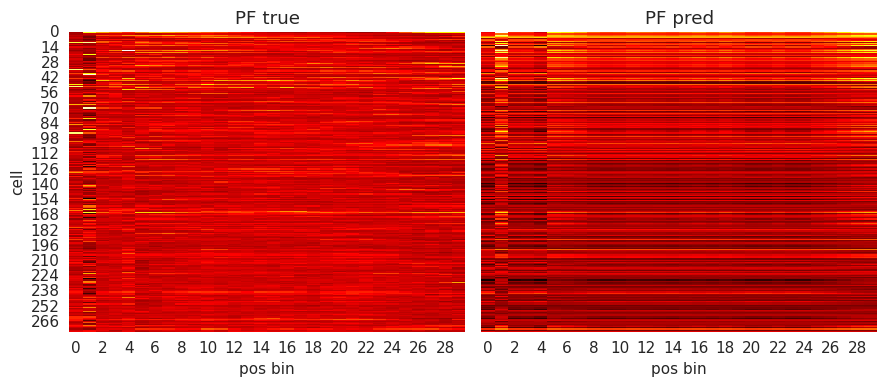

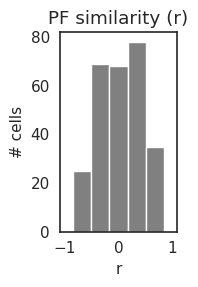

PF r mean=0.039 ± 0.024 (n=275)


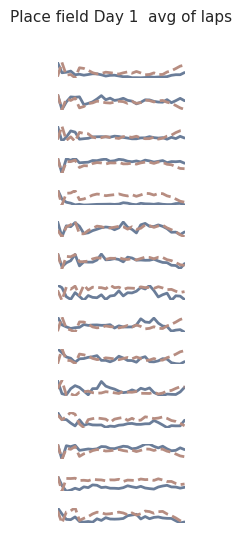

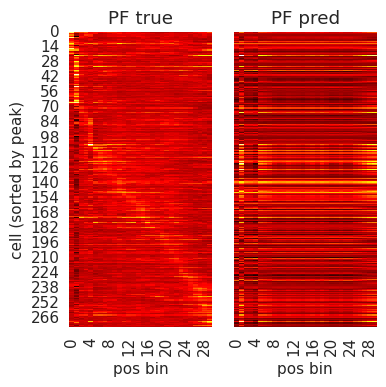

In [15]:
# # ===============================================================
# #  ADVANCED VISUALS + METRICS  (with optional lap‑averaging)
# # ===============================================================
# import numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from scipy.stats import pearsonr
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# sns.set_style("white")

# # ------------------ 0. KNOBS ------------------
# REST_DAY      = 1      # which session to analyse
# LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
# NUM_BINS      = 30
# AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY

# # ------------------ 1. COLLECT / AVERAGE  ---------------------
# Ws = model.weights(T)
# W_day = Ws[REST_DAY]

# def reconstruct(lap_idx):
#     x_t = x_sess[REST_DAY][lap_idx].to(device)
#     v_t = v_sess[REST_DAY][lap_idx].to(device)
#     u_t = u_sess[REST_DAY][lap_idx].cpu().numpy()
#     K   = v_t.size(0)
#     with torch.no_grad():
#         x_p=[x_t[0]]
#         for k in range(K-1):
#             x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
#         x_p  = torch.stack(x_p).cpu()                    # [K,N]
#         u_p  = (model.R @ x_p.T).squeeze().cpu().numpy() # [K]
#     return x_t.cpu(), x_p, u_t, u_p, K

# if AVG_OVER_LAPS:
#     all_x_true = []; all_x_pred = []; all_u_true = []; all_u_pred = []
#     K_max = max(len(v) for v in v_sess[REST_DAY])
#     for li in range(len(x_sess[REST_DAY])):
#         xT,xP,uT,uP,K = reconstruct(li)
#         pad = (K_max-K,0)  # pad at *front* so starts align
#         all_x_true.append(torch.nn.functional.pad(xT, pad=(0,0,*pad)))
#         all_x_pred.append(torch.nn.functional.pad(xP, pad=(0,0,*pad)))
#         all_u_true.append(np.pad(uT, pad, constant_values=np.nan))
#         all_u_pred.append(np.pad(uP, pad, constant_values=np.nan))
#     x_true = torch.stack(all_x_true).nanmean(0)   # [K_max,N]
#     x_pred = torch.stack(all_x_pred).nanmean(0)
#     u_true = np.nanmean(np.vstack(all_u_true),0)
#     u_pred = np.nanmean(np.vstack(all_u_pred),0)
#     K_seq  = K_max
# else:  # single lap path
#     x_true,x_pred,u_true,u_pred,K_seq = reconstruct(LAP_ID)[:5]




# # ------------------ 6. Place‑field maps ----------------------
# pos_bins=np.linspace(u_true.min(),u_true.max(),NUM_BINS+1)
# bin_idx=np.digitize(u_true,pos_bins)-1
# def pf(x):
#     P=np.zeros((NUM_BINS,x.shape[1]))
#     for b in range(NUM_BINS):
#         if not (bin_idx==b).any(): continue
#         P[b]=x[bin_idx==b].mean(0)
#     return P.T
# pf_true,pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

# fig,axs=plt.subplots(1,2,figsize=(9,4),sharey=True)
# sns.heatmap(pf_true,ax=axs[0],cmap='hot',cbar=False);axs[0].set_title('PF true')
# sns.heatmap(pf_pred,ax=axs[1],cmap='hot',cbar=False);axs[1].set_title('PF pred')
# for ax in axs: ax.set_xlabel('pos bin'); axs[0].set_ylabel('cell')
# plt.tight_layout(); plt.show()







# # ------------------ 7. PF similarity histogram --------------
# corrs=[pearsonr(pf_true[i],pf_pred[i])[0]
#        for i in range(pf_true.shape[0]) if pf_true[i].std() and pf_pred[i].std()]
# plt.figure(figsize=(2,3))
# plt.hist(corrs,bins=5,color='gray')
# plt.title('PF similarity (r)'); plt.xlabel('r'); plt.xlim([-1.1,1.1]);plt.ylabel('# cells'); plt.tight_layout(); plt.show()
# print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f}")








# # ===============================================================
# #  PRETTIER PF‑OVERLAY GRID   (bug‑fixed)
# # ===============================================================
# def plot_pf_overlays(pf_true, pf_pred,
#                      cells_to_show=15, cols=1, title=""):

#     import numpy as np, matplotlib.pyplot as plt, seaborn as sns
#     sns.set_style("white")

#     # 1) normalise 0‑1 per cell
#     def minmax(a):
#         mn=a.min(1,keepdims=True); mx=a.max(1,keepdims=True)
#         return (a-mn)/(mx-mn+1e-9)
#     pfT = minmax(pf_true);  pfP = minmax(pf_pred)

#     # 2) sort by peak of true
#     order = np.argsort(np.argmax(pf_true,1))
#     pfT, pfP = pfT[order], pfP[order]

#     # 3) subset
#     pfT, pfP = pfT[:cells_to_show], pfP[:cells_to_show]

#     # 4) plot
#     rows = int(np.ceil(cells_to_show/cols))
#     fig,ax_arr = plt.subplots(rows, cols,
#                               figsize=(cols*1.5, 5),
#                               squeeze=False,
#                               sharex=True, sharey=True)
#     xb = np.arange(pfT.shape[1])

#     true_color = (106/255, 125/255, 153/255)
#     pred_color = (183/255, 141/255, 129/255)

#     for idx in range(cells_to_show):
#         r,c = divmod(idx, cols)
#         ax  = ax_arr[r,c]
#         ax.plot(xb, pfT[idx], color=true_color, lw=2)
#         ax.plot(xb, pfP[idx], '--', color=pred_color, lw=2)
#         ax.set_xlim(0, pfT.shape[1]-1); ax.set_ylim(0,1)
#         ax.set_xticks([]); ax.set_yticks([])
#         # ax.set_title(f'cell {order[idx]}', fontsize=7, pad=2)
#         # -------- fixed: hide spines properly --------
#         for sp in ax.spines.values():
#             sp.set_visible(False)
#         ax.grid(alpha=0.15)

#     # hide empty panels
#     for ax in ax_arr.ravel()[cells_to_show:]:
#         ax.axis('off')

#     # tiny legend
#     l_ax = ax_arr[0,-1]
#     l_ax.plot([],[],color='tab:red',label='true',lw=2)
#     l_ax.plot([],[],color='tab:blue',ls='--',label='pred',lw=2)
#     # l_ax.legend(frameon=False, fontsize=7, loc='upper left')

#     # fig.suptitle(title, y=1.02, fontsize=12)
#     plt.tight_layout()
#     plt.show()

# # ---------- call it ----------
# plot_pf_overlays(
#     pf_true, pf_pred,
#     cells_to_show=15, cols=1,
#     title=f"Place field Day {REST_DAY}  "
#           f'{"avg of laps" if AVG_OVER_LAPS else f"lap {LAP_ID}"}')





# # ------------------ 6. Place‑field maps (now ordered) ----------------------
# pos_bins = np.linspace(u_true.min(), u_true.max(), NUM_BINS+1)
# bin_idx  = np.digitize(u_true, pos_bins) - 1

# def pf(x):
#     P = np.zeros((NUM_BINS, x.shape[1]))
#     for b in range(NUM_BINS):
#         if (bin_idx == b).any():
#             P[b] = x[bin_idx == b].mean(0)
#     return P.T                                            # [cells, pos‑bin]

# pf_true, pf_pred = pf(x_true.numpy()), pf(x_pred.numpy())

# # ---- 1) sort cells exactly as in the overlay plot ----
# order   = np.argsort(np.argmax(pf_true, axis=1))          # peak‑location sort
# pf_true = pf_true[order]
# pf_pred = pf_pred[order]

# # ---- 2) heatmaps with the same cell order ----
# fig, axs = plt.subplots(1, 2, figsize=(4, 4), sharey=True)
# sns.heatmap(pf_true, ax=axs[0], cmap='hot',  cbar=False); axs[0].set_title('PF true')
# sns.heatmap(pf_pred, ax=axs[1], cmap='hot',  cbar=False); axs[1].set_title('PF pred')
# for ax in axs:
#     ax.set_xlabel('pos bin')
# axs[0].set_ylabel('cell (sorted by peak)')
# plt.tight_layout(); plt.show()








# ===============================================================
#  ADVANCED VISUALS + METRICS  (with optional lap-averaging)
#  Device-safe + padding-safe rewrite (incl. PF overlay grid + ordered heatmaps)
# ===============================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

sns.set_style("white")

# ------------------ 0. KNOBS ------------------
REST_DAY      = 1      # which session to analyse
LAP_ID        = 3      # ignored if AVG_OVER_LAPS = True
NUM_BINS      = 30
AVG_OVER_LAPS = True   # <- turn ON to average across all laps on REST_DAY


# ------------------ helpers -------------------
def _model_device(m: torch.nn.Module) -> torch.device:
    try:
        return next(m.parameters()).device
    except StopIteration:
        return next(m.buffers()).device

def _to_device(x, device: torch.device):
    if torch.is_tensor(x):
        return x.to(device)
    if isinstance(x, (list, tuple)):
        return type(x)(_to_device(xx, device) for xx in x)
    if isinstance(x, dict):
        return {k: _to_device(v, device) for k, v in x.items()}
    return x

def _as_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x


# ------------------ 1. COLLECT / AVERAGE ---------------------
device = _model_device(model)
model.eval()

Ws    = _to_device(model.weights(T), device)
W_day = _to_device(Ws[REST_DAY], device)

# Ensure R follows model device even if it isn't registered as a buffer
R = _to_device(model.R, device)

def reconstruct(lap_idx: int):
    """
    Returns CPU tensors + numpy arrays:
      x_t_cpu: [K, N]
      x_p_cpu: [K, N]
      u_t:     [K] numpy
      u_p:     [K] numpy
      K:       int
    """
    x_t = x_sess[REST_DAY][lap_idx].to(device)
    v_t = v_sess[REST_DAY][lap_idx].to(device)
    u_t = _as_numpy(u_sess[REST_DAY][lap_idx])
    K   = int(v_t.size(0))

    with torch.no_grad():
        x_p = [x_t[0]]
        for k in range(K - 1):
            x_p.append(model.rnn_cell(x_p[-1], v_t[k], W_day))
        x_p = torch.stack(x_p)                # [K, N] on device
        u_p = _as_numpy((R @ x_p.T).squeeze())  # [K] numpy

    return x_t.detach().cpu(), x_p.detach().cpu(), u_t, u_p, K

if AVG_OVER_LAPS:
    L = len(x_sess[REST_DAY])
    K_max = max(int(v.size(0)) for v in v_sess[REST_DAY])

    all_x_true, all_x_pred = [], []
    all_u_true, all_u_pred = [], []

    for li in range(L):
        xT, xP, uT, uP, K = reconstruct(li)
        padK = K_max - K

        # torch: pad along time (front) with zeros; we'll use a mask to ignore pads
        all_x_true.append(torch.nn.functional.pad(xT, pad=(0, 0, padK, 0)))  # [K_max, N]
        all_x_pred.append(torch.nn.functional.pad(xP, pad=(0, 0, padK, 0)))

        # numpy: pad front with NaNs so nanmean ignores pads
        all_u_true.append(np.pad(uT, (padK, 0), constant_values=np.nan))
        all_u_pred.append(np.pad(uP, (padK, 0), constant_values=np.nan))

    X_true = torch.stack(all_x_true, dim=0)  # [L, K_max, N]
    X_pred = torch.stack(all_x_pred, dim=0)

    # mask = 1 where valid frames, 0 where padded
    mask = torch.zeros((L, K_max, 1), dtype=X_true.dtype)
    for li in range(L):
        K = int(v_sess[REST_DAY][li].size(0))
        mask[li, K_max - K:, 0] = 1.0

    denom = mask.sum(0).clamp_min(1.0)       # [K_max, 1]
    x_true = (X_true * mask).sum(0) / denom  # [K_max, N] CPU torch
    x_pred = (X_pred * mask).sum(0) / denom

    u_true = np.nanmean(np.vstack(all_u_true), axis=0)
    u_pred = np.nanmean(np.vstack(all_u_pred), axis=0)

    K_seq = K_max
else:
    x_true, x_pred, u_true, u_pred, K_seq = reconstruct(LAP_ID)


# ------------------ 2. Place-field maps ----------------------
# Bin by *true* position; if averaging introduced NaNs, ignore them for binning.
valid = np.isfinite(u_true)
u_for_bins = u_true[valid]

pos_bins = np.linspace(u_for_bins.min(), u_for_bins.max(), NUM_BINS + 1)
bin_idx = np.full(u_true.shape, -1, dtype=int)
bin_idx[valid] = np.digitize(u_for_bins, pos_bins) - 1

def pf_from_traj(x_np: np.ndarray) -> np.ndarray:
    """
    x_np: [K, N] where K matches u_true length
    returns: [N, NUM_BINS] (cells x pos-bin)
    """
    P = np.zeros((NUM_BINS, x_np.shape[1]))
    for b in range(NUM_BINS):
        m = (bin_idx == b)
        if not m.any():
            continue
        P[b] = x_np[m].mean(0)
    return P.T

pf_true = pf_from_traj(x_true.numpy())
pf_pred = pf_from_traj(x_pred.numpy())

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
sns.heatmap(pf_true, ax=axs[0], cmap='hot', cbar=False); axs[0].set_title('PF true')
sns.heatmap(pf_pred, ax=axs[1], cmap='hot', cbar=False); axs[1].set_title('PF pred')
for ax in axs:
    ax.set_xlabel('pos bin')
axs[0].set_ylabel('cell')
plt.tight_layout(); plt.show()


# ------------------ 3. PF similarity histogram ----------------
corrs = [
    pearsonr(pf_true[i], pf_pred[i])[0]
    for i in range(pf_true.shape[0])
    if pf_true[i].std() and pf_pred[i].std()
]

plt.figure(figsize=(2, 3))
plt.hist(corrs, bins=5, color='gray')
plt.title('PF similarity (r)')
plt.xlabel('r')
plt.xlim([-1.1, 1.1])
plt.ylabel('# cells')
plt.tight_layout(); plt.show()

if len(corrs) > 0:
    print(f"PF r mean={np.mean(corrs):.3f} ± {np.std(corrs)/np.sqrt(len(corrs)):.3f} (n={len(corrs)})")
else:
    print("PF similarity: no valid cells (all-zero/constant PFs).")


# ===============================================================
#  PRETTIER PF-OVERLAY GRID
# ===============================================================
def plot_pf_overlays(
    pf_true: np.ndarray,
    pf_pred: np.ndarray,
    cells_to_show: int = 15,
    cols: int = 1,
    title: str = ""
):
    sns.set_style("white")

    def minmax(a):
        mn = a.min(1, keepdims=True)
        mx = a.max(1, keepdims=True)
        return (a - mn) / (mx - mn + 1e-9)

    # normalize 0-1 per cell
    pfT = minmax(pf_true)
    pfP = minmax(pf_pred)

    # sort by peak location of true PF
    order = np.argsort(np.argmax(pf_true, axis=1))
    pfT, pfP = pfT[order], pfP[order]

    # subset
    cells_to_show = min(cells_to_show, pfT.shape[0])
    pfT, pfP = pfT[:cells_to_show], pfP[:cells_to_show]

    rows = int(np.ceil(cells_to_show / cols))
    fig, ax_arr = plt.subplots(
        rows, cols,
        figsize=(cols * 1.6, max(2.5, rows * 0.35)),
        squeeze=False,
        sharex=True, sharey=True
    )

    xb = np.arange(pfT.shape[1])

    true_color = (106/255, 125/255, 153/255)
    pred_color = (183/255, 141/255, 129/255)

    for idx in range(cells_to_show):
        r, c = divmod(idx, cols)
        ax = ax_arr[r, c]
        ax.plot(xb, pfT[idx], color=true_color, lw=2)
        ax.plot(xb, pfP[idx], '--', color=pred_color, lw=2)
        ax.set_xlim(0, pfT.shape[1] - 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        for sp in ax.spines.values():
            sp.set_visible(False)
        ax.grid(alpha=0.15)

    # hide empty panels
    for ax in ax_arr.ravel()[cells_to_show:]:
        ax.axis('off')

    # optional title
    if title:
        fig.suptitle(title, y=1.01, fontsize=11)

    plt.tight_layout()
    plt.show()

# ---------- call it ----------
plot_pf_overlays(
    pf_true, pf_pred,
    cells_to_show=15, cols=1,
    title=f"Place field Day {REST_DAY}  "
          f'{"avg of laps" if AVG_OVER_LAPS else f"lap {LAP_ID}"}'
)


# ------------------ 4. Ordered PF heatmaps (same order as overlay) ----------
order = np.argsort(np.argmax(pf_true, axis=1))  # peak-location sort
pf_true_ord = pf_true[order]
pf_pred_ord = pf_pred[order]

fig, axs = plt.subplots(1, 2, figsize=(4, 4), sharey=True)
sns.heatmap(pf_true_ord, ax=axs[0], cmap='hot', cbar=False); axs[0].set_title('PF true')
sns.heatmap(pf_pred_ord, ax=axs[1], cmap='hot', cbar=False); axs[1].set_title('PF pred')
for ax in axs:
    ax.set_xlabel('pos bin')
axs[0].set_ylabel('cell (sorted by peak)')
plt.tight_layout(); plt.show()


/tmp/ipykernel_2497/4293809552.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


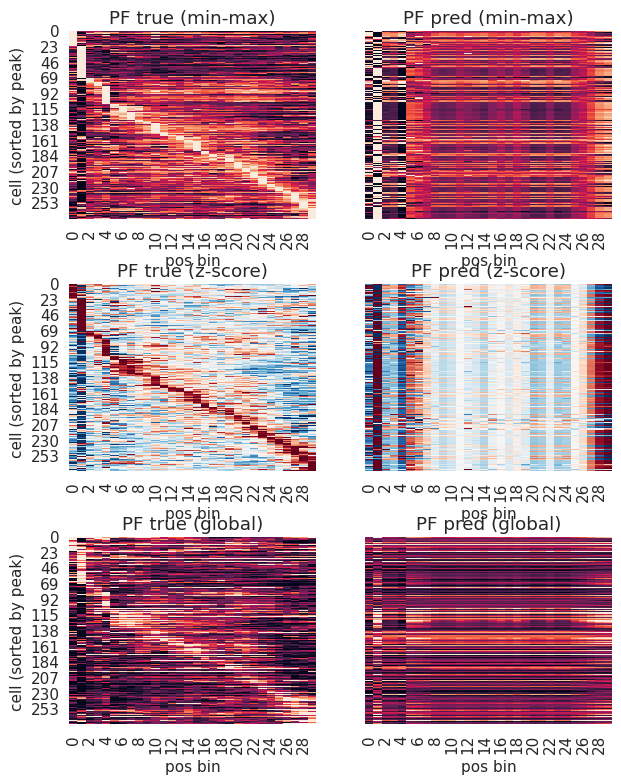

In [16]:
# ============================================================
#  Unified PF‑heatmap visualiser: min‑max | z‑score | global
# ============================================================
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set_style("white")

def minmax(a):
    mn = a.min(1, keepdims=True)
    mx = a.max(1, keepdims=True)
    return (a - mn) / (mx - mn + 1e-9)

def zscore(a):
    mu = a.mean(1, keepdims=True)
    sd = a.std(1, keepdims=True) + 1e-9
    return (a - mu) / sd

def build_heatmaps(pf_true, pf_pred, order):
    """Show three comparable heatmaps for place‑fields:
       1) per‑cell min‑max (0–1)
       2) per‑cell z‑score (diverging palette)
       3) raw values, shared global limits.
    """
    # ––– reorder according to overlay plot –––
    pfT = pf_true[order]
    pfP = pf_pred[order]
    
    # 1) min‑max 0‑1
    pfT_minmax = minmax(pfT)
    pfP_minmax = minmax(pfP)
    
    # 2) z‑score
    pfT_z = zscore(pfT)
    pfP_z = zscore(pfP)
    
    # 3) global limits (5th–95th pct for robustness)
    vmin = np.percentile(np.hstack([pfT, pfP]), 5)
    vmax = np.percentile(np.hstack([pfT, pfP]), 95)
    
    # ––– plotting –––
    fig, axs = plt.subplots(3, 2, figsize=(7, 9), sharey=True,
                            gridspec_kw={"hspace":0.35})
    titles = ['PF true', 'PF pred']
    
    # --- row 0 : min‑max ---
    for j,(data,t) in enumerate([(pfT_minmax,titles[0]), (pfP_minmax,titles[1])]):
        sns.heatmap(data, ax=axs[0,j], cmap='rocket',
                    vmin=0, vmax=1, cbar=False)
        axs[0,j].set_title(f"{t} (min‑max)")
    
    # --- row 1 : z‑score ---
    for j,(data,t) in enumerate([(pfT_z,titles[0]), (pfP_z,titles[1])]):
        sns.heatmap(data, ax=axs[1,j], cmap='RdBu_r',
                    center=0, vmin=-2, vmax=2, cbar=False)
        axs[1,j].set_title(f"{t} (z‑score)")
    
    # --- row 2 : global scale ---
    for j,(data,t) in enumerate([(pfT,titles[0]), (pfP,titles[1])]):
        sns.heatmap(data, ax=axs[2,j], cmap='rocket',
                    vmin=vmin, vmax=vmax, cbar=False)
        axs[2,j].set_title(f"{t} (global)")
    
    # shared labels
    for ax in axs.ravel():
        ax.set_xlabel('pos bin')
    for i in range(3):
        axs[i,0].set_ylabel('cell (sorted by peak)')
    
    plt.tight_layout()
    plt.show()

# -------- call once --------
build_heatmaps(pf_true, pf_pred, order)


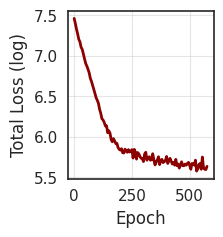

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Manually input the epoch and total loss values
epochs = np.arange(0, 576, 5)
loss_total = [
    1741, 1636, 1526, 1439, 1343, 1302, 1218, 1186, 1118, 1054,
    996, 964, 927, 887, 829, 798, 759, 723, 687, 652,
    632, 609, 565, 539, 503, 495, 481, 460, 461, 423,
    433, 421, 389, 378, 393, 382, 370, 371, 352, 344,
    341, 347, 330, 329, 345, 338, 332, 343, 333, 336,
    343, 309, 344, 333, 305, 331, 325, 315, 308, 307,
    296, 325, 332, 301, 310, 314, 301, 303, 326, 302,
    284, 294, 302, 314, 285, 301, 304, 292, 297, 298,
    315, 289, 299, 308, 297, 287, 293, 283, 304, 281,
    287, 273, 284, 295, 281, 281, 287, 283, 289, 293,
    282, 269, 289, 288, 283, 301, 263, 271, 285, 289,
    269, 313, 273, 269, 268, 279
]

# Create the plot
plt.figure(figsize=(2.5, 2.5))
plt.plot(epochs, np.log(loss_total), linewidth=2, color='darkred')
# plt.scatter(epochs, loss_total, color='gray', edgecolor='black', zorder=5, s=4)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Total Loss (log)", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2497/493385226.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


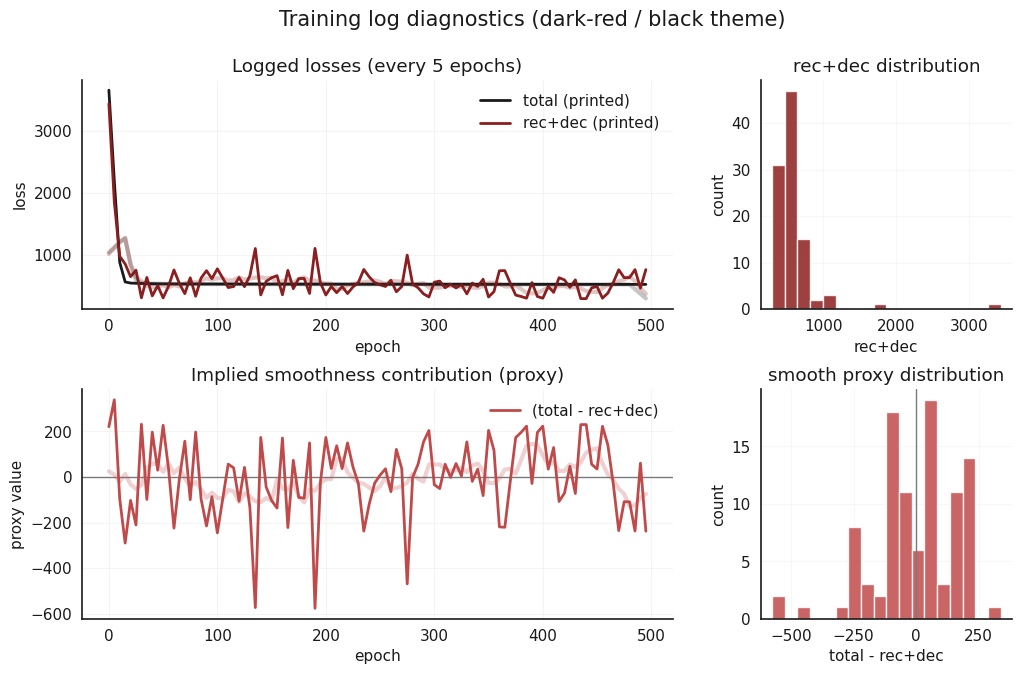

In [18]:
import re
import numpy as np
import matplotlib.pyplot as plt

DARK_RED = "#8B1E1E"
BLACK    = "#1A1A1A"
GRAY     = "#7A7A7A"
LIGHTRED = "#C04A4A"

plt.rcParams.update({
    "font.size": 11,
    "axes.edgecolor": BLACK,
    "axes.labelcolor": BLACK,
    "xtick.color": BLACK,
    "ytick.color": BLACK,
    "text.color": BLACK,
    "axes.linewidth": 1.2,
})

train_log = r"""
Epoch 000 | total 3.649e+03 | rec+dec 3.429e+03
Epoch 005 | total 2.192e+03 | rec+dec 1.854e+03
Epoch 010 | total 8.811e+02 | rec+dec 9.773e+02
Epoch 015 | total 5.657e+02 | rec+dec 8.556e+02
Epoch 020 | total 5.476e+02 | rec+dec 6.504e+02
Epoch 025 | total 5.438e+02 | rec+dec 7.545e+02
Epoch 030 | total 5.410e+02 | rec+dec 3.101e+02
Epoch 035 | total 5.390e+02 | rec+dec 6.378e+02
Epoch 040 | total 5.374e+02 | rec+dec 3.412e+02
Epoch 045 | total 5.362e+02 | rec+dec 5.068e+02
Epoch 050 | total 5.352e+02 | rec+dec 3.087e+02
Epoch 055 | total 5.345e+02 | rec+dec 4.985e+02
Epoch 060 | total 5.340e+02 | rec+dec 7.584e+02
Epoch 065 | total 5.334e+02 | rec+dec 5.414e+02
Epoch 070 | total 5.330e+02 | rec+dec 3.767e+02
Epoch 075 | total 5.327e+02 | rec+dec 6.325e+02
Epoch 080 | total 5.325e+02 | rec+dec 3.359e+02
Epoch 085 | total 5.322e+02 | rec+dec 6.292e+02
Epoch 090 | total 5.321e+02 | rec+dec 7.471e+02
Epoch 095 | total 5.319e+02 | rec+dec 6.184e+02
Epoch 100 | total 5.314e+02 | rec+dec 7.767e+02
Epoch 105 | total 5.313e+02 | rec+dec 6.258e+02
Epoch 110 | total 5.311e+02 | rec+dec 4.751e+02
Epoch 115 | total 5.311e+02 | rec+dec 4.913e+02
Epoch 120 | total 5.310e+02 | rec+dec 6.372e+02
Epoch 125 | total 5.309e+02 | rec+dec 4.891e+02
Epoch 130 | total 5.306e+02 | rec+dec 6.651e+02
Epoch 135 | total 5.305e+02 | rec+dec 1.103e+03
Epoch 140 | total 5.305e+02 | rec+dec 3.575e+02
Epoch 145 | total 5.302e+02 | rec+dec 5.746e+02
Epoch 150 | total 5.301e+02 | rec+dec 6.333e+02
Epoch 155 | total 5.299e+02 | rec+dec 6.664e+02
Epoch 160 | total 5.297e+02 | rec+dec 3.593e+02
Epoch 165 | total 5.297e+02 | rec+dec 7.516e+02
Epoch 170 | total 5.295e+02 | rec+dec 4.566e+02
Epoch 175 | total 5.295e+02 | rec+dec 6.193e+02
Epoch 180 | total 5.294e+02 | rec+dec 6.226e+02
Epoch 185 | total 5.293e+02 | rec+dec 3.804e+02
Epoch 190 | total 5.292e+02 | rec+dec 1.105e+03
Epoch 195 | total 5.290e+02 | rec+dec 5.519e+02
Epoch 200 | total 5.290e+02 | rec+dec 3.561e+02
Epoch 205 | total 5.288e+02 | rec+dec 4.919e+02
Epoch 210 | total 5.292e+02 | rec+dec 3.927e+02
Epoch 215 | total 5.287e+02 | rec+dec 4.922e+02
Epoch 220 | total 5.286e+02 | rec+dec 3.795e+02
Epoch 225 | total 5.286e+02 | rec+dec 4.848e+02
Epoch 230 | total 5.284e+02 | rec+dec 5.580e+02
Epoch 235 | total 5.286e+02 | rec+dec 7.660e+02
Epoch 240 | total 5.283e+02 | rec+dec 6.470e+02
Epoch 245 | total 5.282e+02 | rec+dec 5.555e+02
Epoch 250 | total 5.281e+02 | rec+dec 5.204e+02
Epoch 255 | total 5.281e+02 | rec+dec 4.925e+02
Epoch 260 | total 5.281e+02 | rec+dec 5.927e+02
Epoch 265 | total 5.279e+02 | rec+dec 4.072e+02
Epoch 270 | total 5.278e+02 | rec+dec 4.920e+02
Epoch 275 | total 5.279e+02 | rec+dec 9.966e+02
Epoch 280 | total 5.278e+02 | rec+dec 5.301e+02
Epoch 285 | total 5.277e+02 | rec+dec 4.723e+02
Epoch 290 | total 5.277e+02 | rec+dec 3.747e+02
Epoch 295 | total 5.276e+02 | rec+dec 3.241e+02
Epoch 300 | total 5.276e+02 | rec+dec 5.617e+02
Epoch 305 | total 5.277e+02 | rec+dec 5.788e+02
Epoch 310 | total 5.274e+02 | rec+dec 4.719e+02
Epoch 315 | total 5.272e+02 | rec+dec 5.295e+02
Epoch 320 | total 5.273e+02 | rec+dec 4.686e+02
Epoch 325 | total 5.272e+02 | rec+dec 5.231e+02
Epoch 330 | total 5.272e+02 | rec+dec 3.736e+02
Epoch 335 | total 5.273e+02 | rec+dec 5.468e+02
Epoch 340 | total 5.271e+02 | rec+dec 4.934e+02
Epoch 345 | total 5.270e+02 | rec+dec 6.090e+02
Epoch 350 | total 5.270e+02 | rec+dec 3.231e+02
Epoch 355 | total 5.269e+02 | rec+dec 4.105e+02
Epoch 360 | total 5.268e+02 | rec+dec 7.458e+02
Epoch 365 | total 5.269e+02 | rec+dec 7.476e+02
Epoch 370 | total 5.268e+02 | rec+dec 5.470e+02
Epoch 375 | total 5.268e+02 | rec+dec 3.543e+02
Epoch 380 | total 5.268e+02 | rec+dec 3.317e+02
Epoch 385 | total 5.267e+02 | rec+dec 3.043e+02
Epoch 390 | total 5.268e+02 | rec+dec 5.558e+02
Epoch 395 | total 5.266e+02 | rec+dec 3.318e+02
Epoch 400 | total 5.266e+02 | rec+dec 3.041e+02
Epoch 405 | total 5.265e+02 | rec+dec 4.924e+02
Epoch 410 | total 5.265e+02 | rec+dec 3.977e+02
Epoch 415 | total 5.265e+02 | rec+dec 6.340e+02
Epoch 420 | total 5.265e+02 | rec+dec 5.974e+02
Epoch 425 | total 5.263e+02 | rec+dec 4.796e+02
Epoch 430 | total 5.263e+02 | rec+dec 5.991e+02
Epoch 435 | total 5.264e+02 | rec+dec 2.973e+02
Epoch 440 | total 5.262e+02 | rec+dec 2.968e+02
Epoch 445 | total 5.262e+02 | rec+dec 4.705e+02
Epoch 450 | total 5.262e+02 | rec+dec 4.916e+02
Epoch 455 | total 5.261e+02 | rec+dec 3.043e+02
Epoch 460 | total 5.262e+02 | rec+dec 3.868e+02
Epoch 465 | total 5.261e+02 | rec+dec 5.581e+02
Epoch 470 | total 5.262e+02 | rec+dec 7.615e+02
Epoch 475 | total 5.259e+02 | rec+dec 6.345e+02
Epoch 480 | total 5.261e+02 | rec+dec 6.355e+02
Epoch 485 | total 5.261e+02 | rec+dec 7.634e+02
Epoch 490 | total 5.259e+02 | rec+dec 4.656e+02
Epoch 495 | total 5.260e+02 | rec+dec 7.638e+02
""".strip()

def parse_log(txt):
    pat = re.compile(r"Epoch\s+(\d+)\s+\|\s+total\s+([0-9.eE+-]+)\s+\|\s+rec\+dec\s+([0-9.eE+-]+)")
    ep, tot, rd = [], [], []
    for m in pat.finditer(txt):
        ep.append(int(m.group(1)))
        tot.append(float(m.group(2)))
        rd.append(float(m.group(3)))
    ep = np.array(ep)
    tot = np.array(tot)
    rd = np.array(rd)
    smooth_proxy = tot - rd
    return ep, tot, rd, smooth_proxy

ep, total, recdec, smooth_proxy = parse_log(train_log)


def moving_avg(x, w=5):
    if w <= 1:
        return x
    k = np.ones(w) / w
    return np.convolve(x, k, mode="same")

def plot_logged_losses(ep, total, recdec, smooth_proxy, smooth_w=7):
    fig = plt.figure(figsize=(12, 7))
    gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.35)

    ax0 = fig.add_subplot(gs[0, :2])  # main loss curves
    ax1 = fig.add_subplot(gs[1, :2])  # smooth proxy
    ax2 = fig.add_subplot(gs[0, 2])   # hist recdec
    ax3 = fig.add_subplot(gs[1, 2])   # hist smooth proxy

    # ---- (A) Curves
    ax0.plot(ep, total, color=BLACK, lw=2, label="total (printed)")
    ax0.plot(ep, recdec, color=DARK_RED, lw=2, label="rec+dec (printed)")
    ax0.plot(ep, moving_avg(total, smooth_w), color=BLACK, lw=3, alpha=0.25)
    ax0.plot(ep, moving_avg(recdec, smooth_w), color=DARK_RED, lw=3, alpha=0.25)
    ax0.set_title("Logged losses (every 5 epochs)")
    ax0.set_xlabel("epoch")
    ax0.set_ylabel("loss")
    ax0.legend(frameon=False, loc="upper right")
    ax0.grid(alpha=0.2)

    # ---- (B) Smoothness proxy
    ax1.axhline(0.0, color=GRAY, lw=1)
    ax1.plot(ep, smooth_proxy, color=LIGHTRED, lw=2, label="(total - rec+dec)")
    ax1.plot(ep, moving_avg(smooth_proxy, smooth_w), color=LIGHTRED, lw=3, alpha=0.25)
    ax1.set_title("Implied smoothness contribution (proxy)")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("proxy value")
    ax1.legend(frameon=False, loc="upper right")
    ax1.grid(alpha=0.2)

    # ---- (C) Histograms
    ax2.hist(recdec, bins=18, color=DARK_RED, alpha=0.85)
    ax2.set_title("rec+dec distribution")
    ax2.set_xlabel("rec+dec")
    ax2.set_ylabel("count")
    ax2.grid(alpha=0.15)

    ax3.hist(smooth_proxy, bins=18, color=LIGHTRED, alpha=0.85)
    ax3.axvline(0.0, color=GRAY, lw=1)
    ax3.set_title("smooth proxy distribution")
    ax3.set_xlabel("total - rec+dec")
    ax3.set_ylabel("count")
    ax3.grid(alpha=0.15)

    # cosmetics
    for ax in [ax0, ax1, ax2, ax3]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    fig.suptitle("Training log diagnostics (dark-red / black theme)", fontsize=15, y=0.98)
    plt.tight_layout()
    plt.show()

plot_logged_losses(ep, total, recdec, smooth_proxy, smooth_w=7)



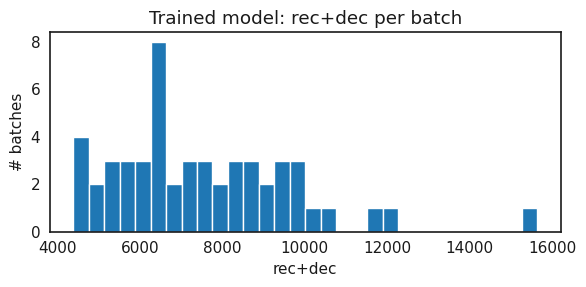

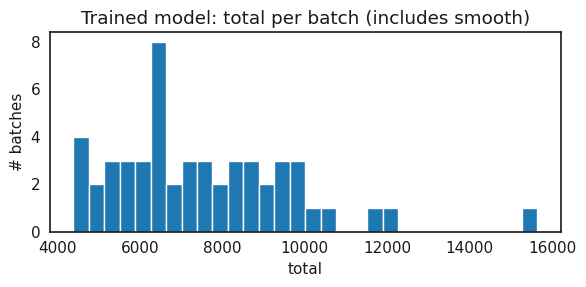

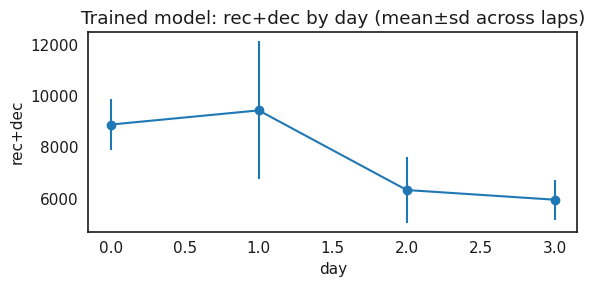

Smooth term (unweighted): 7.311e-01
Smooth term (weighted):   3.656e-02


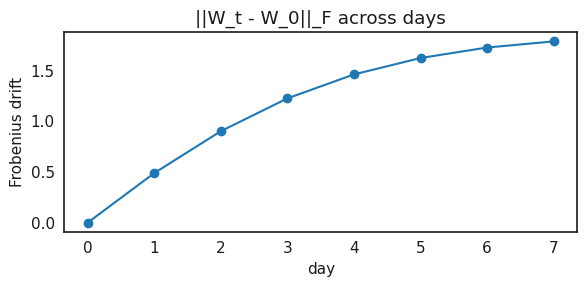

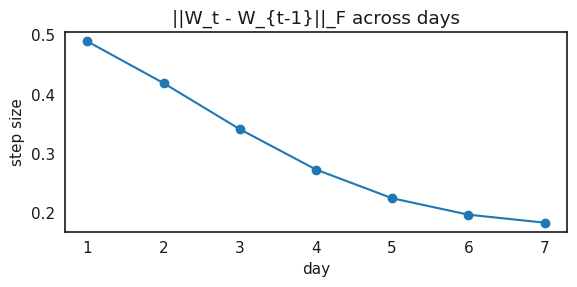

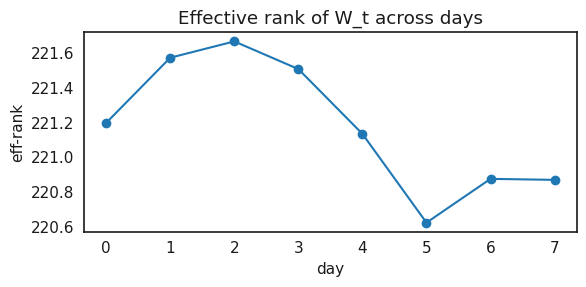

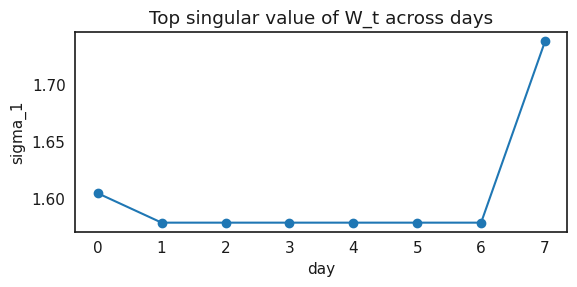

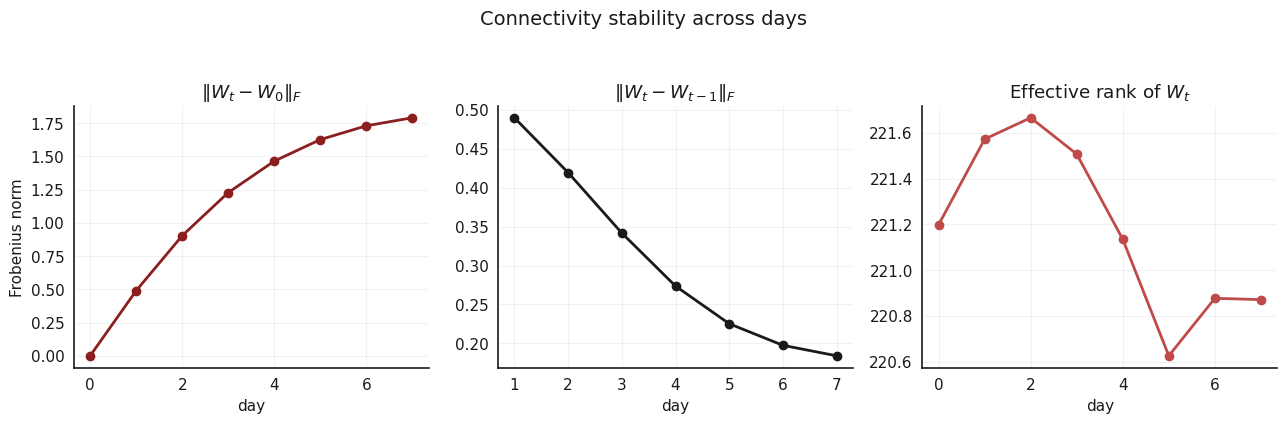

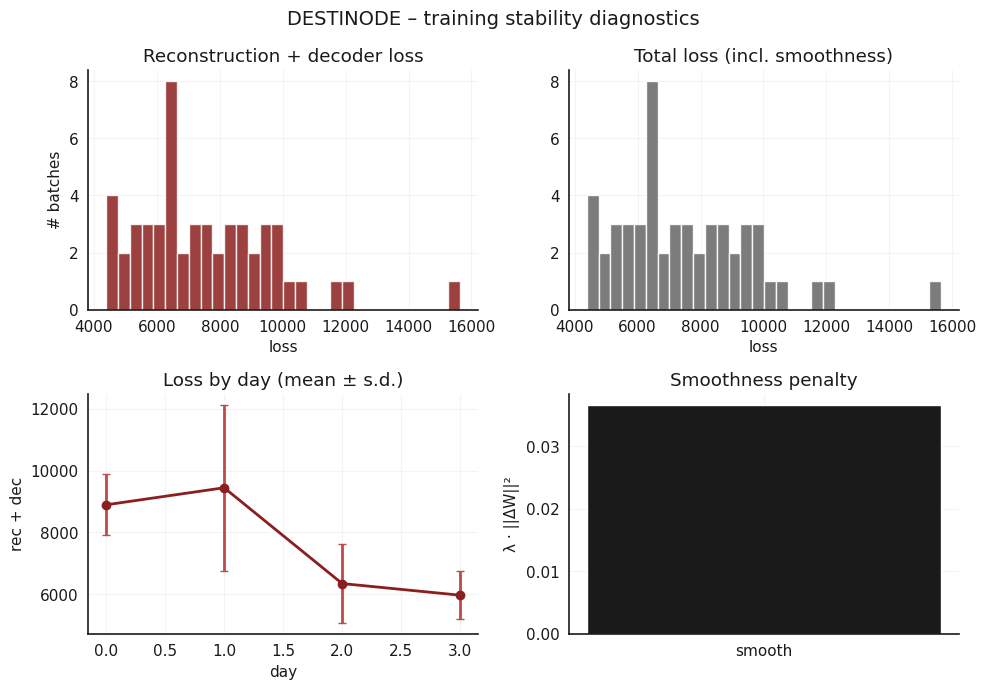

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def eval_losses(model, loader, T, LAMBDA_SMOOTH, device):
    model.eval()
    Ws = model.weights(T)

    # smoothness term is global (doesn't depend on batch)
    smooth = (Ws[1:] - Ws[:-1]).pow(2).sum().item()
    smooth_weighted = LAMBDA_SMOOTH * smooth

    total_list = []
    recdec_list = []
    day_list = []

    for batch in loader:  # batch is a list of tuples because collate_fn=lambda b:b
        losses = []
        days = []
        for x_gt, v_gt, u_gt, t_idx in batch:
            x_gt = x_gt.to(device); v_gt = v_gt.to(device); u_gt = u_gt.to(device)
            losses.append(model(x_gt, v_gt, u_gt, t_idx, Ws).item())
            days.append(int(t_idx))
        recdec = float(np.mean(losses))
        total = recdec + smooth_weighted
        total_list.append(total)
        recdec_list.append(recdec)
        day_list.append(days[0] if len(days) else None)

    return {
        "total_per_batch": np.array(total_list),
        "recdec_per_batch": np.array(recdec_list),
        "day_per_batch": np.array(day_list),
        "smooth": smooth,
        "smooth_weighted": smooth_weighted,
        "Ws_cpu": Ws.detach().cpu(),
    }

def plot_eval_report(report, title="Final-model evaluation"):
    total = report["total_per_batch"]
    recdec = report["recdec_per_batch"]
    days = report["day_per_batch"]

    # ---- 1) overall distributions
    plt.figure(figsize=(6,3))
    plt.hist(recdec, bins=30)
    plt.title(f"{title}: rec+dec per batch")
    plt.xlabel("rec+dec"); plt.ylabel("# batches")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.hist(total, bins=30)
    plt.title(f"{title}: total per batch (includes smooth)")
    plt.xlabel("total"); plt.ylabel("# batches")
    plt.tight_layout(); plt.show()

    # ---- 2) per-day means
    uniq = np.unique(days)
    means = [recdec[days==d].mean() for d in uniq]
    stds  = [recdec[days==d].std()  for d in uniq]

    plt.figure(figsize=(6,3))
    plt.errorbar(uniq, means, yerr=stds, fmt='o-')
    plt.title(f"{title}: rec+dec by day (mean±sd across laps)")
    plt.xlabel("day"); plt.ylabel("rec+dec")
    plt.tight_layout(); plt.show()

    print(f"Smooth term (unweighted): {report['smooth']:.3e}")
    print(f"Smooth term (weighted):   {report['smooth_weighted']:.3e}")

def weight_stability_plots(Ws_cpu):
    """
    Ws_cpu: [T, N, N] on CPU
    """
    Ws = Ws_cpu
    T = Ws.shape[0]

    # Frobenius drift from day 0
    W0 = Ws[0]
    drift = torch.stack([(Ws[t]-W0).pow(2).sum().sqrt() for t in range(T)]).numpy()

    plt.figure(figsize=(6,3))
    plt.plot(np.arange(T), drift, 'o-')
    plt.title("||W_t - W_0||_F across days")
    plt.xlabel("day"); plt.ylabel("Frobenius drift")
    plt.tight_layout(); plt.show()

    # Step-to-step changes
    step = torch.stack([(Ws[t]-Ws[t-1]).pow(2).sum().sqrt() for t in range(1,T)]).numpy()
    plt.figure(figsize=(6,3))
    plt.plot(np.arange(1,T), step, 'o-')
    plt.title("||W_t - W_{t-1}||_F across days")
    plt.xlabel("day"); plt.ylabel("step size")
    plt.tight_layout(); plt.show()

    # Singular spectrum summary (effective rank proxy)
    # eff-rank = exp(H(p)) where p are normalized singular values
    effr = []
    top_s = []
    for t in range(T):
        s = torch.linalg.svdvals(Ws[t])
        p = (s / (s.sum() + 1e-12)).clamp_min(1e-12)
        H = -(p * p.log()).sum()
        effr.append(float(torch.exp(H)))
        top_s.append(float(s[0]))
    effr = np.array(effr); top_s = np.array(top_s)

    plt.figure(figsize=(6,3))
    plt.plot(np.arange(T), effr, 'o-')
    plt.title("Effective rank of W_t across days")
    plt.xlabel("day"); plt.ylabel("eff-rank")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(np.arange(T), top_s, 'o-')
    plt.title("Top singular value of W_t across days")
    plt.xlabel("day"); plt.ylabel("sigma_1")
    plt.tight_layout(); plt.show()




import matplotlib.pyplot as plt
import numpy as np

DARK_RED = "#8B1E1E"
LIGHT_RED = "#C04A4A"
BLACK = "#1A1A1A"
GRAY = "#6E6E6E"

plt.rcParams.update({
    "font.size": 11,
    "axes.labelcolor": BLACK,
    "axes.edgecolor": BLACK,
    "axes.linewidth": 1.2,
    "xtick.color": BLACK,
    "ytick.color": BLACK,
    "text.color": BLACK,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})



def plot_training_stability(report, title="Model evaluation (post-training)"):
    recdec = report["recdec_per_batch"]
    total  = report["total_per_batch"]
    days   = report["day_per_batch"]

    uniq_days = np.unique(days)
    means = [recdec[days == d].mean() for d in uniq_days]
    stds  = [recdec[days == d].std()  for d in uniq_days]

    fig, axs = plt.subplots(2, 2, figsize=(10, 7))
    fig.suptitle(title, fontsize=14, y=0.98)

    # ---- (a) rec+dec distribution
    axs[0,0].hist(recdec, bins=30, color=DARK_RED, alpha=0.85)
    axs[0,0].set_title("Reconstruction + decoder loss")
    axs[0,0].set_xlabel("loss")
    axs[0,0].set_ylabel("# batches")

    # ---- (b) total loss distribution
    axs[0,1].hist(total, bins=30, color=GRAY, alpha=0.9)
    axs[0,1].set_title("Total loss (incl. smoothness)")
    axs[0,1].set_xlabel("loss")

    # ---- (c) per-day mean ± std
    axs[1,0].errorbar(
        uniq_days, means, yerr=stds,
        fmt="o-", lw=2,
        color=DARK_RED, ecolor=LIGHT_RED,
        capsize=3
    )
    axs[1,0].set_title("Loss by day (mean ± s.d.)")
    axs[1,0].set_xlabel("day")
    axs[1,0].set_ylabel("rec + dec")

    # ---- (d) smoothness magnitude
    axs[1,1].bar(
        ["smooth"],
        [report["smooth_weighted"]],
        color=BLACK
    )
    axs[1,1].set_title("Smoothness penalty")
    axs[1,1].set_ylabel("λ · ||ΔW||²")

    for ax in axs.ravel():
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()


def plot_weight_stability(Ws_cpu):
    """
    Ws_cpu: [T, N, N] torch tensor on CPU
    """
    Ws = Ws_cpu
    T = Ws.shape[0]
    days = np.arange(T)

    # ---- metrics
    W0 = Ws[0]
    drift = torch.stack([(Ws[t] - W0).pow(2).sum().sqrt() for t in range(T)]).numpy()
    step  = torch.stack([(Ws[t] - Ws[t-1]).pow(2).sum().sqrt()
                          for t in range(1, T)]).numpy()

    eff_rank = []
    top_sv   = []
    for t in range(T):
        s = torch.linalg.svdvals(Ws[t])
        p = (s / s.sum()).clamp_min(1e-12)
        H = -(p * p.log()).sum()
        eff_rank.append(float(torch.exp(H)))
        top_sv.append(float(s[0]))

    fig, axs = plt.subplots(1, 3, figsize=(13, 4))
    fig.suptitle("Connectivity stability across days", fontsize=14, y=1.05)

    # ---- (a) drift from day 0
    axs[0].plot(days, drift, "o-", color=DARK_RED, lw=2)
    axs[0].set_title(r"$\|W_t - W_0\|_F$")
    axs[0].set_xlabel("day")
    axs[0].set_ylabel("Frobenius norm")

    # ---- (b) step-to-step change
    axs[1].plot(days[1:], step, "o-", color=BLACK, lw=2)
    axs[1].set_title(r"$\|W_t - W_{t-1}\|_F$")
    axs[1].set_xlabel("day")

    # ---- (c) effective rank
    axs[2].plot(days, eff_rank, "o-", color=LIGHT_RED, lw=2)
    axs[2].set_title("Effective rank of $W_t$")
    axs[2].set_xlabel("day")

    for ax in axs:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(alpha=0.25)

    plt.tight_layout()
    plt.show()



# ---- run evaluation on trained model ----
report = eval_losses(model, loader, T=T, LAMBDA_SMOOTH=LAMBDA_SMOOTH, device=device)
plot_eval_report(report, title="Trained model")
weight_stability_plots(report["Ws_cpu"])

plot_weight_stability(report["Ws_cpu"])
plot_training_stability(report, title="DESTINODE – training stability diagnostics")



In [20]:
import time, platform, torch
import numpy as np

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

def get_device_info(device):
    if device.type == "cuda":
        i = torch.cuda.current_device()
        name = torch.cuda.get_device_name(i)
        cap = torch.cuda.get_device_capability(i)
        mem_gb = torch.cuda.get_device_properties(i).total_memory / (1024**3)
        return f"{name} (CUDA cc {cap[0]}.{cap[1]}, {mem_gb:.1f} GB)"
    return "CPU"

# ---- static info ----
print("=== Compute / system ===")
print("PyTorch:", torch.__version__)
print("Device:", device)
print("GPU:", get_device_info(device))
print("CPU:", platform.processor() or platform.platform())
print("Trainable params:", f"{count_params(model):,}")

# ---- data scale ----
num_sessions = len(x_sess)
laps_per_day = [len(x_sess[d]) for d in range(num_sessions)]
Ks = [x.shape[0] for d in range(num_sessions) for x in x_sess[d]]
print("\n=== Data scale ===")
print("Sessions:", num_sessions)
print("Laps per session:", laps_per_day)
print("Seq length K: mean±sd =", f"{np.mean(Ks):.1f}±{np.std(Ks):.1f}",
      "| min/max =", (int(np.min(Ks)), int(np.max(Ks))))
print("Neurons N:", x_sess[0][0].shape[1])

# ---- quick timing: a few training steps (no full retrain) ----
def time_steps(n_steps=20):
    model.train()
    t0 = time.time()
    it = iter(loader)
    for _ in range(n_steps):
        batch = next(it)
        Ws = model.weights(T)
        losses=[]
        for x_gt, v_gt, u_gt, t_idx in batch:
            x_gt, v_gt, u_gt = x_gt.to(device), v_gt.to(device), u_gt.to(device)
            losses.append(model(x_gt, v_gt, u_gt, t_idx, Ws))
        rec_dec = torch.stack(losses).mean()
        smooth  = (Ws[1:]-Ws[:-1]).pow(2).sum()
        loss = rec_dec + LAMBDA_SMOOTH*smooth
        loss.backward()
        model.zero_grad(set_to_none=True)
    if device.type == "cuda":
        torch.cuda.synchronize()
    dt = time.time() - t0
    return dt / n_steps

sec_per_step = time_steps(n_steps=20)
print("\n=== Timing (approx) ===")
print(f"Seconds per optimization step (batch_size=1): {sec_per_step:.4f}s")
print("Note: total runtime ≈ sec_per_step × (#batches per epoch) × (#epochs)")


=== Compute / system ===
PyTorch: 2.8.0+cu128
Device: cuda:0
GPU: NVIDIA H200 (CUDA cc 9.0, 139.8 GB)
CPU: x86_64
Trainable params: 1,279

=== Data scale ===
Sessions: 8
Laps per session: [12, 12, 14, 14, 12, 12, 13, 12]
Seq length K: mean±sd = 692.6±148.5 | min/max = (419, 1521)
Neurons N: 275

=== Timing (approx) ===
Seconds per optimization step (batch_size=1): 0.2778s
Note: total runtime ≈ sec_per_step × (#batches per epoch) × (#epochs)
